# Installations and set up

In [4]:
%%capture
!pip install biopython PyBioMed
!pip install catboost optuna
!pip install pymsaviz
!pip install py3Dmol

Export dependencies for reproducibility:

In [2]:
!pip freeze > requirements.txt

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

### Helper functions

In [6]:
def draw_heatmap(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                linewidths=.5, cbar_kws={"shrink": .8}, square=True)

    # Add title and adjust layout
    plt.title('Correlation Heatmap of df_descriptors', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the heatmap
    plt.show()

### Loading data

In [7]:
# Чтение файла с пропуском проблемных строк
try:
    poseidon_df = pd.read_csv('POSEIDON.csv', encoding='windows-1252', on_bad_lines='skip')
    print(poseidon_df.head())
except Exception as e:
    print(f"Ошибка при чтении файла: {e}")

       Peptide     Cell line        Cargo  PubmedID Uptake  \
0  Tat (49-57)  Jurkat cells  Fluorescein  11087855    650   
1  Tat (49-56)  Jurkat cells  Fluorescein  11087855  31.25   
2  Tat (49-55)  Jurkat cells  Fluorescein  11087855     10   
3  Tat (50-57)  Jurkat cells  Fluorescein  11087855   22.5   
4  Tat (51-57)  Jurkat cells  Fluorescein  11087855     20   

                         Units    Conc.    Time Temp.          Method  \
0  Mean Fluorescence intensity  12.5 uM  15 min  23ºC  Flow cytometry   
1  Mean Fluorescence intensity  12.5 uM  10 min  23ºC  Flow cytometry   
2  Mean Fluorescence intensity  12.5 uM  10 min  23ºC  Flow cytometry   
3  Mean Fluorescence intensity  12.5 uM  10 min  23ºC  Flow cytometry   
4  Mean Fluorescence intensity  12.5 uM  10 min  23ºC  Flow cytometry   

              Type   Sequence  
0  Cellular uptake  RKKRRQRRR  
1  Cellular uptake   RKKRRQRR  
2  Cellular uptake    RKKRRQR  
3  Cellular uptake   KKRRQRRR  
4  Cellular uptake    KRRQRR

In [8]:
poseidon_df.head()

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15 min 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10 min 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10 min 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10 min 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10 min 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR

In [9]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Peptide    2094 non-null   object
 1   Cell line  2084 non-null   object
 2   Cargo      2029 non-null   object
 3   PubmedID   2095 non-null   int64 
 4   Uptake     2095 non-null   object
 5   Units      2059 non-null   object
 6   Conc.      1903 non-null   object
 7   Time       2006 non-null   object
 8   Temp.      1537 non-null   object
 9   Method     2087 non-null   object
 10  Type       2086 non-null   object
 11  Sequence   2091 non-null   object
dtypes: int64(1), object(11)
memory usage: 196.5+ KB


In [10]:
poseidon_df.isna().sum()

Peptide 1
Cell line 11
Cargo 66
PubmedID 0
Uptake 0
Units 36
Conc. 192
Time 89
Temp. 558
Method 8
Type 9
Sequence 4
dtype: int64

In [11]:
poseidon_df = poseidon_df.dropna(subset=['Sequence'])

In [12]:
poseidon_df.duplicated().sum()

5

In [13]:
poseidon_df = poseidon_df.drop_duplicates()

In [14]:
poseidon_df.duplicated().sum()

0

In [15]:
def fasta_to_df(fasta_file):
    # Считываем файл с указанием кодировки
    with open(fasta_file, "r", encoding="utf-8") as file:
        records = list(SeqIO.parse(file, "fasta"))

    data = []
    for record in records:
        data.append({
            "ID": record.id,
            "Description": record.description,
            "Sequence": str(record.seq)
        })

    return pd.DataFrame(data)

In [16]:
def parse_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Инициализация списков для хранения данных
    indices = []
    uptake_types = []
    sequences = []
    
    # Перебор строк и извлечение данных
    for line in lines:
        line = line.strip()  # Удаляем пробелы и символы новой строки
        if line.startswith('>'):
            # Разделяем строки по символу '|'
            parts = line[1:].split('|')
            indices.append(parts[0].strip())
            uptake_types.append(parts[1].strip())
        else:
            sequences.append(line)
    
    # Создаем DataFrame
    df = pd.DataFrame({
        'index': indices,
        'uptake_type': uptake_types,
        'sequence': sequences
    })
    
    return df

# Путь к файлу
file_path = 'Balanced_dataset.txt'

# Получаем DataFrame
df = parse_file(file_path)

# Preprocessing

### Quantitative data for regression models

In [17]:
import re

In [18]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Peptide    2085 non-null   object
 1   Cell line  2075 non-null   object
 2   Cargo      2020 non-null   object
 3   PubmedID   2086 non-null   int64 
 4   Uptake     2086 non-null   object
 5   Units      2050 non-null   object
 6   Conc.      1895 non-null   object
 7   Time       1997 non-null   object
 8   Temp.      1528 non-null   object
 9   Method     2078 non-null   object
 10  Type       2077 non-null   object
 11  Sequence   2086 non-null   object
dtypes: int64(1), object(11)
memory usage: 211.9+ KB


In [19]:
poseidon_df['Conc.'].unique()

array(['12.5 uM', '1.8 uM', '44 uM', '40 uM', '2.5 uM', '200 uM',
 '1600 uM', '0.05 umol', '50 uM', '10 uM', '5 uM', '5 umol/L',
 'Charge ratio = 5:1 (MPG/DNA)', 'Charge ratio = 10:1', '300 uM',
 '5 umol/l', '6 uM', '15 uM', '4 uM', '2 uM', nan,
 '100:1 molar excess of siRNAs', 'N/P ratio 20', '100 nM siRNA',
 '100 nM', '5 mM', 'N/P ratio 10',
 'Equal to a DOX dose of 10 ug/mL', '3 uM', '1 uM', '10 umol/L',
 '100 uM siRNA', 'Charge ratio = 0.5 / Charge ratio 5',
 '10^4 particles', '2 ug/ml', '25 uM', '57 umol/L', '5 ug/ml',
 '1 nM', '200 ug/ml', '8 mM Trehalose', '13 uM', '8 uM', '16 uM',
 '8 uM MCoTI-II / 16 uM SFTI-1', '100 nmol/kg', '10 uM BSH-11R',
 '10 uM BSH-11R (Boron concentration)', '1.5 ug/mL lipossomes',
 '40 ug/ml', '30 ug/ml', '25 µg/ml', '4 uM CPP', '150 uM',
 'Final Concentration between 1/5 uM', '10000 nM', '0.15 uM',
 '100 uM', '500 nM', 'Charge ratio = 10', '10 nM', '2.1 uM',
 '10 ug/ml', 'charge ratio = 2', '3 nmol',
 'Molar ratio 50 (v/w) or (w/w) eGFP', '1.0 mg/ml', '1 umol',
 'N/P ratio = 3', '100 ug/ml', '0.5 uM', 'N/P ratio 6',
 'plasmid/PDL ratio 1:4', '1.5 nM', '5 ug',
 'pDNA/peptide ratio 1:2500', '10 ug/mL',
 '2 uM dox equivalent concentration', '50 ug/ml', '0.5uM', '1uM',
 '2uM', '5uM', '10uM', '15uM', '20uM', '30uM', '40uM', '50uM',
 '1.9 uM', '5.6 uM', '16.7 uM', '6.3 uM', '25uM', '37 kBq', '20 uM',
 '12 uM', '0.2uM', '2.5uM', '7.5uM', '6uM', '100 ug/mL', '4uM',
 '100nM', '40 ug /mL', '0.1uM', '30 uM', '1.25uM', '9.0 uM', '25nM',
 '50nM', '200nM', '0.002ug/mL', '0.25uM', '25 ug/mL', '20 ug/ml',
 '100ug/ml', '0.1ug/ml', '100 mg/L', '20ug', '2ug/mL', '7uM', '3uM',
 '2.5', '3.9mg/ml', '16uM', '6ug/mL', '12ug/mL', '25ug/mL', '100uM',
 '0.01uM', '3000 pmol', '25ug/ml', '2mg/ml', '10ug', '600 ug/ml',
 '1 mg/ml', '2ug/ml', '5ug/ml', '100ug'], dtype=object)

In [20]:
poseidon_df['Time'].unique()

array(['15 min', '10 min', '30 min', '2h', '60 min', '18h', '3h', nan,
 '1h', '4h', '65 min', '45 min', '6h', '30 min.', '2.5 h', '48h',
 '2 h', '20 min', '24h', '70 min', '12h', '120 min', '1 h', '3 h',
 '8 hour', '48 h', '16h', '22h', '30min', '10min', '45min', '0.1h',
 '0.25h', '0.5h', '1.5h', '8h', '120min', '15min', '5min', '90min',
 '100s'], dtype=object)

In [21]:
def time_to_minutes(time_str):
    '''
    Функция пересчитывает значения столбца Time в минуты. Префиксы (s, min, h)
    удаляет
    '''
    if pd.isna(time_str):
        return np.nan  # Возвращаем NaN для пропущенных значений

    time_str = time_str.strip().lower()  # Приводим строку к нижнему регистру и убираем пробелы

    # Преобразуем значения в минуты в зависимости от единиц времени
    if 'h' in time_str:
        if 'hour' in time_str:
            time_str = time_str.replace('hour', '')
        time_str = time_str.replace('h', '')
        try:
            hours = float(time_str)
            return hours * 60
        except ValueError:
            return np.nan
    elif 'min' in time_str:
        time_str = time_str.replace('min', '').replace(' ', '')
        try:
            minutes = float(time_str)
            return minutes
        except ValueError:
            return np.nan
    elif 's' in time_str:
        time_str = time_str.replace('s', '').replace(' ', '')
        try:
            seconds = float(time_str)
            return seconds / 60
        except ValueError:
            return np.nan
    else:
        try:
            return float(time_str)
        except ValueError:
            return np.nan

In [22]:
poseidon_df['Time'] = poseidon_df['Time'].apply(time_to_minutes)

In [23]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Peptide    2085 non-null   object 
 1   Cell line  2075 non-null   object 
 2   Cargo      2020 non-null   object 
 3   PubmedID   2086 non-null   int64  
 4   Uptake     2086 non-null   object 
 5   Units      2050 non-null   object 
 6   Conc.      1895 non-null   object 
 7   Time       1997 non-null   float64
 8   Temp.      1528 non-null   object 
 9   Method     2078 non-null   object 
 10  Type       2077 non-null   object 
 11  Sequence   2086 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 211.9+ KB


In [25]:
poseidon_df.head()

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23ºC 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR

In [26]:
poseidon_df['Temp.'].unique()

array(['23ºC', '37ºC', '4ºC', nan, '37°C', '25ºC', '27ºC', '26ºC', '42ºC',
 '28ºC'], dtype=object)

In [27]:
def remove_celsius(value):
    '''
    Функция убирает символы ºC из строки с показанием температуры
    '''
    # Проверка на nan
    if pd.isna(value):
        return value

    value = str(value)[:-2]
    value = int(value)

    # Удаление последних двух символов
    return value

In [28]:
poseidon_df['Temp.'] = poseidon_df['Temp.'].apply(remove_celsius)

In [29]:
poseidon_df.head(10)

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR 
 
 
 5 
 D-Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 1800 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 rkkrrqrrr 
 
 
 6 
 Retro - Tat (57-49) 
 Jurkat cells 
 Fluorescein 
 11087855 
 2450 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RRRQRRKKR 
 
 
 7 
 D-Tat (57-49) 
 Jurkat cells 
 Fluorescein 
 11087855 
 3600 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 rrrqrrkkr 
 
 
 8 
 Ala49 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 16.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 AKKRRQRRR 
 
 
 9 
 Ala50 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 32.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RAKRRQRRR

In [30]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Peptide    2085 non-null   object 
 1   Cell line  2075 non-null   object 
 2   Cargo      2020 non-null   object 
 3   PubmedID   2086 non-null   int64  
 4   Uptake     2086 non-null   object 
 5   Units      2050 non-null   object 
 6   Conc.      1895 non-null   object 
 7   Time       1997 non-null   float64
 8   Temp.      1528 non-null   float64
 9   Method     2078 non-null   object 
 10  Type       2077 non-null   object 
 11  Sequence   2086 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 211.9+ KB


In [31]:
poseidon_df['Conc.'].unique()

array(['12.5 uM', '1.8 uM', '44 uM', '40 uM', '2.5 uM', '200 uM',
 '1600 uM', '0.05 umol', '50 uM', '10 uM', '5 uM', '5 umol/L',
 'Charge ratio = 5:1 (MPG/DNA)', 'Charge ratio = 10:1', '300 uM',
 '5 umol/l', '6 uM', '15 uM', '4 uM', '2 uM', nan,
 '100:1 molar excess of siRNAs', 'N/P ratio 20', '100 nM siRNA',
 '100 nM', '5 mM', 'N/P ratio 10',
 'Equal to a DOX dose of 10 ug/mL', '3 uM', '1 uM', '10 umol/L',
 '100 uM siRNA', 'Charge ratio = 0.5 / Charge ratio 5',
 '10^4 particles', '2 ug/ml', '25 uM', '57 umol/L', '5 ug/ml',
 '1 nM', '200 ug/ml', '8 mM Trehalose', '13 uM', '8 uM', '16 uM',
 '8 uM MCoTI-II / 16 uM SFTI-1', '100 nmol/kg', '10 uM BSH-11R',
 '10 uM BSH-11R (Boron concentration)', '1.5 ug/mL lipossomes',
 '40 ug/ml', '30 ug/ml', '25 µg/ml', '4 uM CPP', '150 uM',
 'Final Concentration between 1/5 uM', '10000 nM', '0.15 uM',
 '100 uM', '500 nM', 'Charge ratio = 10', '10 nM', '2.1 uM',
 '10 ug/ml', 'charge ratio = 2', '3 nmol',
 'Molar ratio 50 (v/w) or (w/w) eGFP', '1.0 mg/ml', '1 umol',
 'N/P ratio = 3', '100 ug/ml', '0.5 uM', 'N/P ratio 6',
 'plasmid/PDL ratio 1:4', '1.5 nM', '5 ug',
 'pDNA/peptide ratio 1:2500', '10 ug/mL',
 '2 uM dox equivalent concentration', '50 ug/ml', '0.5uM', '1uM',
 '2uM', '5uM', '10uM', '15uM', '20uM', '30uM', '40uM', '50uM',
 '1.9 uM', '5.6 uM', '16.7 uM', '6.3 uM', '25uM', '37 kBq', '20 uM',
 '12 uM', '0.2uM', '2.5uM', '7.5uM', '6uM', '100 ug/mL', '4uM',
 '100nM', '40 ug /mL', '0.1uM', '30 uM', '1.25uM', '9.0 uM', '25nM',
 '50nM', '200nM', '0.002ug/mL', '0.25uM', '25 ug/mL', '20 ug/ml',
 '100ug/ml', '0.1ug/ml', '100 mg/L', '20ug', '2ug/mL', '7uM', '3uM',
 '2.5', '3.9mg/ml', '16uM', '6ug/mL', '12ug/mL', '25ug/mL', '100uM',
 '0.01uM', '3000 pmol', '25ug/ml', '2mg/ml', '10ug', '600 ug/ml',
 '1 mg/ml', '2ug/ml', '5ug/ml', '100ug'], dtype=object)

In [32]:
poseidon_df['Conc.'].value_counts().head(20)

10uM 176
10 uM 170
5 uM 124
1uM 85
2uM 82
5uM 75
2.5 uM 70
50 uM 68
1 nM 65
1 uM 57
2.1 uM 49
25uM 41
5 ug 40
40 uM 40
50uM 38
100nM 33
12.5 uM 30
2 uM 27
1.8 uM 24
5 mM 24
Name: Conc., dtype: int64

In [33]:
def convert_to_uM(value):
    '''
    Функция приведения концентрации пептида + груза к общему виду (uM)
    '''
    
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip().lower()
    
    # Обработка молекулярных отношений и других нечисловых значений
    if re.search(r'\d+:\d+', value):
        return np.nan  # Или какое-то другое значение по умолчанию
    
    # Конвертация единиц измерения
    try:
        if 'um' in value:
            return float(value.split()[0])
        elif 'mm' in value:
            return float(value.split()[0]) * 1000
        elif 'nm' in value:
            return float(value.split()[0]) / 1000
        elif 'umol' in value:
            return float(value.split()[0]) * 1000
        elif 'mol' in value:
            return float(value.split()[0]) * 1e6
        elif 'ug/ml' in value:
            return float(value.split()[0]) / 0.1  # Примерное преобразование (все зависит от конкретного контекста)
        elif 'mg/ml' in value:
            return float(value.split()[0]) * 1000
        elif 'nM' in value:
            return float(value.split()[0]) / 1000
        elif 'pmol' in value:
            return float(value.split()[0]) / 1000
        elif 'particles' in value:
            # Обработка особого случая, если это число частиц
            return np.nan
        else:
            # Для других случаев, не определённых выше
            return np.nan
    except ValueError:
        return np.nan

In [34]:
poseidon_df['Conc. (uM)'] = poseidon_df['Conc.'].apply(convert_to_uM)

In [35]:
poseidon_df.head(20)

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 12.5 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 12.5 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 12.5 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 12.5 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR 
 12.5 
 
 
 5 
 D-Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 1800 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 rkkrrqrrr 
 12.5 
 
 
 6 
 Retro - Tat (57-49) 
 Jurkat cells 
 Fluorescein 
 11087855 
 2450 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RRRQRRKKR 
 12.5 
 
 
 7 
 D-Tat (57-49) 
 Jurkat cells 
 Fluorescein 
 11087855 
 3600 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 rrrqrrkkr 
 12.5 
 
 
 8 
 Ala49 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 16.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 AKKRRQRRR 
 12.5 
 
 
 9 
 Ala50 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 32.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RAKRRQRRR 
 12.5 
 
 
 10 
 Ala51 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 37.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKARRQRRR 
 12.5 
 
 
 11 
 Ala52 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKARQRRR 
 12.5 
 
 
 12 
 Ala53 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 30 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRAQRRR 
 12.5 
 
 
 13 
 Ala54 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 132.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRARRR 
 12.5 
 
 
 14 
 Ala55 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 32.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQARR 
 12.5 
 
 
 15 
 Ala56 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 35 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRAR 
 12.5 
 
 
 16 
 Ala57 substitution mutant of Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 12.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRA 
 12.5 
 
 
 17 
 R5 
 Jurkat cells 
 Fluorescein 
 11087855 
 100 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RRRRR 
 12.5 
 
 
 18 
 R6 
 Jurkat cells 
 Fluorescein 
 11087855 
 500 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RRRRRR 
 12.5 
 
 
 19 
 R7 
 Jurkat cells 
 Fluorescein 
 11087855 
 1225 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RRRRRRR 
 12.5

In [36]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Peptide     2085 non-null   object 
 1   Cell line   2075 non-null   object 
 2   Cargo       2020 non-null   object 
 3   PubmedID    2086 non-null   int64  
 4   Uptake      2086 non-null   object 
 5   Units       2050 non-null   object 
 6   Conc.       1895 non-null   object 
 7   Time        1997 non-null   float64
 8   Temp.       1528 non-null   float64
 9   Method      2078 non-null   object 
 10  Type        2077 non-null   object 
 11  Sequence    2086 non-null   object 
 12  Conc. (uM)  1073 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 228.2+ KB


In [37]:
# Заполняем пропуски колонки 'Temp.' медианными значениями
poseidon_df['Temp.'] = poseidon_df['Temp.'].fillna(poseidon_df['Temp.'].median())

In [38]:
# Заполняем пропуски колонки 'Time' медианными значениями
poseidon_df['Time'] = poseidon_df['Time'].fillna(poseidon_df['Time'].median())

In [36]:
# Better to include all this preprocessing to skliearn pipeline, but it's a hackaton...

In [39]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Peptide     2085 non-null   object 
 1   Cell line   2075 non-null   object 
 2   Cargo       2020 non-null   object 
 3   PubmedID    2086 non-null   int64  
 4   Uptake      2086 non-null   object 
 5   Units       2050 non-null   object 
 6   Conc.       1895 non-null   object 
 7   Time        2086 non-null   float64
 8   Temp.       2086 non-null   float64
 9   Method      2078 non-null   object 
 10  Type        2077 non-null   object 
 11  Sequence    2086 non-null   object 
 12  Conc. (uM)  1073 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 228.2+ KB


In [40]:
poseidon_df['Uptake'].unique()

array(['650', '31.25', '10', '22.5', '20', '1800', '2450', '3600',
 '16.25', '32.5', '37.5', '30', '132.5', '35', '12.5', '100', '500',
 '1225', '1700', '2650', '150', '950', '3100', '4400', '5125',
 '228 ± 54', '161 ± 21', '15 ± 6', '%lt;10', '47 ± 7', '68 ± 2',
 '149 ± 20', '15 ± 4', '29 ± 14', '44 ± 10', '218 ± 31', '226 ± 19',
 '341 ± 58', '371 ± 56', '218 ± 23', '%lt;30', '42 ± 12.4', '461 ± 44',
 '5670 ± 3971', '135 ± 14.6', '539 ± 80', '141 ± 54', '0.24',
 '0.26', '0.45', '0.88', '0.18', '100.0', '57', '47.5', '28',
 '19.5', '25', '15', '18', '13', '87', '94', '67', '48', '52', '64',
 '60', '50', '22', '89', '82', '56', '68', '89.5', '90', '61', '42',
 '31', '87.5', '26', '41', '21', '23', '3176', '3344', '1909',
 '4050', '1511', '1516', '1202', '1043', '1583', '1226', '1937',
 '1741', '943', '2044', '1347', '1211', '1256', '872', '1390',
 '405', '2172', '1867', '572', '475', '415', '193', '2656', '2476',
 '2569', '2109', '1713', '1449', '1529', '1229', '1304', '1412',
 '1488', '2376', '3056', '1922', '1943', '734', '162', '2816',
 '1542', '2335', '1188', '987', '615', '496', '856', '1244', '1272',
 '347', '251', '222', '257', '294', '353', '27.5', '55.0', '46.25',
 '97± 4.3', '61±1.7', '1280', '79 ± 1.5', '90 ± 3', '65 ± 3.7',
 '71 ± 2.2', '100 ± 2.3', '47 ± 1.4', '70 ± 4', '80±1.9', '104.5',
 '607.5 / 2400', '626.5', '155', '57 / 75', '76', '33.25',
 '123.5', '1200', '75', '1925', '790', '850', '530', '220', '800',
 '750', '880', '810', '370', '840', '860', '440', '830', '590',
 '890', '1350', '300', '375', '700', '450', '2500', '1125', '2175',
 '1500', '1850', '550', '1550', '2150', '2100', '400', '1150',
 '200', '130', '80', '555', '1300', '1000', '1050', '250', '4', '8',
 '4.5', '7', '40', '33.75', '7.5', '6.25', '4.375', '3.75', '70',
 '5', '11.15', '600', '140', '120', '280', '580', '55', '115',
 '3400', '2700', '14', '3', '2.8', '17.5', '16', '1.5', '0', '575',
 '160', '230', '74', '21.25', '3.13', '2.29', '21.5', '8.13',
 '4.16', '3.54', '1.83', '1.68', '5.41', '2.5', '1.84', '2', '1.6',
 '1', '15.6', '9', '31.16', '43.93', '12.12', '6.06', '3.63',
 '53.13', '46.87', '90.62', '6.6', '6.0', '21.1', '16.2', '15.9',
 '1.2', '1.3', '1.8', '14.4', '12.4', '10.5', '0.9', '0.8', '1.0',
 '2.46', '0.38', '81', '6', '7.1', '45', '260', '195', '187', '211',
 '0.23', '0.85', '57.0', '27.0', '492', '93.2', '52.5', '72.5',
 '57.5', '240', '95', '137.5', '165', '460', '85', '38', '1940',
 '845', '625', '78.3', '16.6', '31.6', '23.3', '79.2', '58.1',
 '98.8', '35.6', '75.2', '99.0', '5900', '86', '9.6', '96', '98.9',
 '53.3', '12812', '7916', '8.0', '0.2', '0.725', '0.3', '5.0',
 '4.7e+5', '9.0e+4', '1.3e+5', '1.4e+5', '1431 ± 307', '1829 ± 335',
 '1789 ± 221', '1300 ± 221', '13000', '2.0', '4.0', '1.25', '190',
 '335', '327', '35.3', '43.8', '32.4', '26.6', '2800', '3900',
 '15900', '0.95', '1.08', '0.52', '1.65', '1.73', '1.95', '1.00',
 '1.17', '1.04', '0.86', '1.13', '1.26', '0.82', '3.0 / 6.0',
 '1.81 ± 0.34', '391.4', '588.8', '219.4', '71', '6000', '3300',
 '7500', '11', '70.0', '60.0', '20.0', '86±3', '97±3', '87±3',
 '95±10', '80.0', '931', '2750', '1527±121', '20.97±0.99',
 '627±124', '18.60±0.82', '24.67', '92', '78.08', '51.07',
 '19.0 ± 2.0', '10.7', '58', '900', '930', '0.84', '0.92', '1.14',
 '0.96', '1.07', '0.98', '1.02', '0.90', '0.83', '0.76', '0.77',
 '0.73', '0.89', '1.18', '1.34', '0.97', '1.06', '0.74', '0.78',
 '15.82', '9.762', '7.990', '82.21', '63.06', '14.75', '23.23',
 '1105.2', '1575', '262.5', '38.0', '48.0', '49.0', '378.0',
 '424.0', '82.46', '78.85', '74.79', '32', '54.54', '18.5', '362.5',
 '3.5', '28.75', '2.25', '3.9', '5.6', '63', '1400', '1.89', '39',
 '56.8', '36', '11.2', '92.8', '23.2', '7.2', '12', '3.2', '98.4',
 '0.205', '19', '0.75', '1.15', '0.5', '112.5', '20.8', '166',
 '208.3', '83.3', '70 ± 5', '0.0', '27 ±13', '70 ± 4', '24', '44',
 '72', '124', '148', '17', '33', '66', '10.375', '0.625', '0.25',
 '65 000', '32.0', '54.0', '9.0', '10.0', '28.0', '16.0', '64.0',
 '74.0', '18.0

In [41]:
def convert_to_float(value):
    try:
        # Удаление пробелов
        value = value.strip()

        # Обработка значений, которые начинаются с нечисловых символов
        value = re.sub(r'[^\d./±eE-]', '', value)

        # Обработка диапазонов
        if '±' in value:
            value = value.split('±')[0].strip()

        # Обработка экспоненциальной нотации
        if 'e' in value or 'E' in value:
            return float(value)

        # Обработка дробей
        if '/' in value:
            numerator, denominator = value.split('/')
            return float(numerator) / float(denominator)

        # Обработка значений в процентах
        if '%' in value:
            value = value.replace('%', '')

        # Преобразование в float
        return float(value)

    except ValueError:
        # Если не удалось распознать значение, вернуть NaN
        return np.nan

In [42]:
poseidon_df['new_uptake'] = poseidon_df['Uptake'].apply(convert_to_float)

In [43]:
poseidon_df['Uptake'].value_counts()

0 74
100 52
10 36
20 31
1 29
 ..
23.23 1
14.75 1
63.06 1
82.21 1
4800 1
Name: Uptake, Length: 755, dtype: int64

In [44]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Peptide     2085 non-null   object 
 1   Cell line   2075 non-null   object 
 2   Cargo       2020 non-null   object 
 3   PubmedID    2086 non-null   int64  
 4   Uptake      2086 non-null   object 
 5   Units       2050 non-null   object 
 6   Conc.       1895 non-null   object 
 7   Time        2086 non-null   float64
 8   Temp.       2086 non-null   float64
 9   Method      2078 non-null   object 
 10  Type        2077 non-null   object 
 11  Sequence    2086 non-null   object 
 12  Conc. (uM)  1073 non-null   float64
 13  new_uptake  2086 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 244.5+ KB


In [45]:
poseidon_df.head(5)

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 new_uptake 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 12.5 
 650.00 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 12.5 
 31.25 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 12.5 
 10.00 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 12.5 
 22.50 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR 
 12.5 
 20.00

In [46]:
poseidon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2094
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Peptide     2085 non-null   object 
 1   Cell line   2075 non-null   object 
 2   Cargo       2020 non-null   object 
 3   PubmedID    2086 non-null   int64  
 4   Uptake      2086 non-null   object 
 5   Units       2050 non-null   object 
 6   Conc.       1895 non-null   object 
 7   Time        2086 non-null   float64
 8   Temp.       2086 non-null   float64
 9   Method      2078 non-null   object 
 10  Type        2077 non-null   object 
 11  Sequence    2086 non-null   object 
 12  Conc. (uM)  1073 non-null   float64
 13  new_uptake  2086 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 244.5+ KB


### Handling ridiculous sequences

In [48]:
# Define the patterns
patterns = {
    "Standard": re.compile(r"^[A-Z]+$"),
    "Modification": re.compile(r"^[A-Za-z]+$"),
    "Chemical Formula": re.compile(r"^[A-Za-z0-9]+-[a-z]+$"),
    "Special Structure": re.compile(r"^[A-Za-z0-9\-]+-BLGTYTQDFNXFHTFPQTAIGVGAP$"),
    "Repeating Segments": re.compile(r"^[A-Za-z0-9\(\)\-]+-NH2$")
}

# Function to categorize sequences
def categorize_sequence(sequence):
    for category, pattern in patterns.items():
        if pattern.match(sequence):
            return category
    return None

In [49]:
# Apply the function to create a new column
poseidon_df['Sequence'].apply(categorize_sequence).value_counts()

Standard 1616
Repeating Segments 144
Modification 75
Chemical Formula 8
Special Structure 2
Name: Sequence, dtype: int64

In [50]:
poseidon_df['Sequence'].apply(categorize_sequence).info()

<class 'pandas.core.series.Series'>
Int64Index: 2086 entries, 0 to 2094
Series name: Sequence
Non-Null Count  Dtype 
--------------  ----- 
1845 non-null   object
dtypes: object(1)
memory usage: 32.6+ KB


In [51]:
pattern = '^\([A-Z][a-zA-Z]*\)-[ACDEFGHIKLMNPQRSTVWY]+|[ACDEFGHIKLMNPQRSTVWY]+-\([A-Z][a-zA-Z]*\)$'
poseidon_df.Sequence.str.contains(pattern, regex=True).sum()

9

In [52]:
poseidon_df[poseidon_df.Sequence.str.contains(pattern, regex=True)].Sequence

974 (Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK
975 (Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK
976 (Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK
977 (Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK
1008 (Acp)-RKRRQTSMTDFYHSKRRLIFS
1009 (Acp)-RKRRQTSMTDFYHSKRRLIFS
1010 (Acp)-RKRRQTSMTDFYHSKRRLIFS
1011 (Acp)-RKRRQTSMTDFYHSKRRLIFS
1012 (Acp)-RKRRQTSMTDFYHSKRRLIFS
Name: Sequence, dtype: object

In [53]:
poseidon_df.Sequence.str.endswith('-NH2').sum()

146

In [54]:
poseidon_df[poseidon_df.Sequence.str.endswith('-NH2')].Sequence

957 stearyl-HHHHHHHHHHHHHHHH-RRRRRRRR-NH2
1022 Mpa(luc)-GSLKTRVLKR-NH2
1023 Mpa(luc)-GSLKTRVLKR-NH2
1024 Mpa(luc)-GSLKTRVLKR-NH2
1025 Mpa(luc)-GSLKTRVLKR-NH2
 ... 
2078 IWLTALKFLGKHAAKHEAKQQLSKL-GK(FITC)-NH2
2079 IWLTALKFLGKHAAKHEAKQQLSKL-GRRGK(FITC)-NH2
2080 IWLTALKFLGKHAAKHEAKQQLSKL-GRRRRGK(FITC)-NH2
2081 RRG-IWLTALKFLGKHAAKHEAKQQLSKL-GK(FITC)-NH2
2082 RRRRG-IWLTALKFLGKHAAKHEAKQQLSKL-GK(FITC)-NH2
Name: Sequence, Length: 146, dtype: object

In [55]:

valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
valid_num = poseidon_df.Sequence.str.contains(valid_pattern, regex=True).sum()
valid_num

1537

In [56]:
def check_valid_ratio(df, col_name):
    valid_num = df[col_name].str.contains(valid_pattern, regex=True).sum()
    print(f"Percentage of fully valid sequences: {valid_num / len(df) * 100:.2f} %")

In [57]:
check_valid_ratio(poseidon_df, 'Sequence')

Percentage of fully valid sequences: 73.68 %


In [58]:
START_END_PATTERN = r'^[^-]+-[ACDEFGHIKLMNPQRSTVWY]+-[^-]+$'

poseidon_df[poseidon_df.Sequence.str.contains(START_END_PATTERN, regex=True)].Sequence

740 ?A-RRRR-[KRRRE]
741 ?A-RRR-[KRRRRE]
742 ?A-RR-[KRRRRRE]
956 RKKRRQRRR-EIWIAQELRRIGDEFNAYYARLL-C
972 poly-L-lysine
 ... 
1902 Z-LRGG-AMC
2025 Acetyl-RLWRLLWRLWRRLWRLLR-NH2
2026 DEG-RLWRLLWRLWRRLWRLLR-NH2
2048 COOH-RRRRRRRRRR-NH2
2049 COOH-KKKKKKKKKK-NH2
Name: Sequence, Length: 76, dtype: object

In [59]:
poseidon_df[~poseidon_df.Sequence.str.contains(valid_pattern, regex=True)].Sequence

5 rkkrrqrrr
7 rrrqrrkkr
22 rrrrr
23 rrrrrr
24 rrrrrrr
 ... 
2082 RRRRG-IWLTALKFLGKHAAKHEAKQQLSKL-GK(FITC)-NH2
2084 KrKiFcL
2085 kRkIfCl
2086 KrKfIcL
2087 kRkFiCl
Name: Sequence, Length: 549, dtype: object

**Let's beat the crap out of these sequences!**

In [60]:
# 1. Function to Find Sequences Ending with -NH2 and Create Categorical Feature nht_tail

def find_nht_tail(sequence):
    """
    Finds sequences ending with -NH2 and creates a categorical feature `nht_tail`.
    Returns 1 if it ends with -NH2, otherwise 0.
    """
    pattern = r'-NH2$'
    return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0

In [61]:
# 2. Function to Remove Sequences Ending with -NH2 and Clean Remaining Sequence

def clean_sequence_nh2(sequence):
    """
    Removes sequences ending with -NH2 and ensures the remaining sequence matches valid_pattern.
    """
    valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
    if pd.notnull(sequence) and sequence.endswith('-NH2'):
        cleaned_sequence = sequence[:-4]  # Remove '-NH2'
        return cleaned_sequence
    return sequence

In [62]:
# 3. Function to Find Sequences Starting with Mpa(luc)- and Clean Sequence

def clean_sequence_mpa(sequence):
    """
    Finds sequences starting with Mpa(luc)- and ensures the remaining sequence matches valid_pattern.
    """
    valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
    if pd.notnull(sequence) and sequence.startswith('Mpa(luc)-'):
        cleaned_sequence = sequence[9:]  # Remove 'Mpa(luc)-'
        return cleaned_sequence
    return sequence

In [63]:
# 4. Function to Find Sequences Starting with Ac- or (Acp)- and Create Categorical Feature acylated_terminal

def find_acylated_terminal(sequence):
    """
    Finds sequences starting with Ac- or (Acp)- and creates a categorical feature `acylated_terminal`.
    Returns 1 if it starts with Ac- or (Acp)-, otherwise 0.
    """
    pattern = r'^(Ac-|\(Acp\)-)'
    return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0

In [64]:
# 5. Function to Remove Sequences Starting with Ac- or (Acp)- and Clean Sequence

def clean_sequence_acylated(sequence):
    """
    Removes sequences starting with Ac- or (Acp)- and ensures the remaining sequence matches valid_pattern.
    """
    valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
    if pd.notnull(sequence):
        if sequence.startswith('Ac-'):
            cleaned_sequence = sequence[3:]  # Remove 'Ac-'
        elif sequence.startswith('(Acp)-'):
            cleaned_sequence = sequence[5:]  # Remove '(Acp)-'
        else:
            return sequence
        
        return cleaned_sequence
    return sequence

In [65]:
# 6. Function to Find Sequences Starting with COOH- and Create Categorical Feature cooh_terminal

def find_cooh_terminal(sequence):
    """
    Finds sequences starting with COOH- and creates a categorical feature `cooh_terminal`.
    Returns 1 if it starts with COOH-, otherwise 0.
    """
    pattern = r'^COOH-'
    return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0

In [66]:
# 7. Function to Remove Sequences Starting with COOH- and Clean Sequence

def clean_sequence_cooh(sequence):
    """
    Removes sequences starting with COOH- and ensures the remaining sequence matches valid_pattern.
    """
    valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
    if pd.notnull(sequence) and sequence.startswith('COOH-'):
        cleaned_sequence = sequence[5:]  # Remove 'COOH-'
        return cleaned_sequence
    return sequence

In [67]:
def process_sequences(input_df, seq_col_name):
    """
    Process the DataFrame to:
    - Create categorical features based on patterns.
    - Modify the 'Sequence' column by applying cleaning functions.
    """
    df = input_df.copy()
    df['cleaned_sequence'] = df[seq_col_name]
    
    # Apply functions to create categorical features
    df['nht_tail'] = df['Sequence'].apply(find_nht_tail)
    df['acylated_terminal'] = df['Sequence'].apply(find_acylated_terminal)
    df['cooh_terminal'] = df['Sequence'].apply(find_cooh_terminal)
    
    # Print counts for categorical features
    print("Count of sequences with nht_tail (ending with -NH2):", df['nht_tail'].sum())
    print("Count of sequences with acylated_terminal (starting with Ac- or (Acp)-):", df['acylated_terminal'].sum())
    print("Count of sequences with cooh_terminal (starting with COOH-):", df['cooh_terminal'].sum())
    
    # Apply cleaning functions and print counts
    pre_clean_count = len(df)
    df['cleaned_sequence'] = df['Sequence'].apply(clean_sequence_nh2)
    print("Count of sequences after removing -NH2:", len(df[df['cleaned_sequence'] != df['Sequence']]))
    
    df['cleaned_sequence'] = df['cleaned_sequence'].apply(clean_sequence_mpa)
    print("Count of sequences after removing Mpa(luc)-:", len(df[df['cleaned_sequence'] != df['Sequence']]))
    
    df['cleaned_sequence'] = df['cleaned_sequence'].apply(clean_sequence_acylated)
    print("Count of sequences after removing Ac- or (Acp)-:", len(df[df['cleaned_sequence'] != df['Sequence']]))
    
    df['cleaned_sequence'] = df['cleaned_sequence'].apply(clean_sequence_cooh)
    print("Count of sequences after removing COOH-:", len(df[df['cleaned_sequence'] != df['Sequence']]))
    
    return df

In [68]:
poseidon_df = process_sequences(poseidon_df, 'Sequence')

Count of sequences with nht_tail (ending with -NH2): 146
Count of sequences with acylated_terminal (starting with Ac- or (Acp)-): 32
Count of sequences with cooh_terminal (starting with COOH-): 2
Count of sequences after removing -NH2: 146
Count of sequences after removing Mpa(luc)-: 146
Count of sequences after removing Ac- or (Acp)-: 159
Count of sequences after removing COOH-: 159


In [69]:
check_valid_ratio(poseidon_df, 'cleaned_sequence')

Percentage of fully valid sequences: 77.04 %


In [70]:
poseidon_df = poseidon_df.rename(columns={'cleaned_sequence': 'clened_sequence_old'})

In [71]:
poseidon_df = process_sequences(poseidon_df, 'clened_sequence_old')

Count of sequences with nht_tail (ending with -NH2): 146
Count of sequences with acylated_terminal (starting with Ac- or (Acp)-): 32
Count of sequences with cooh_terminal (starting with COOH-): 2
Count of sequences after removing -NH2: 146
Count of sequences after removing Mpa(luc)-: 146
Count of sequences after removing Ac- or (Acp)-: 159
Count of sequences after removing COOH-: 159


In [72]:
check_valid_ratio(poseidon_df, 'cleaned_sequence')

Percentage of fully valid sequences: 77.04 %


In [73]:
def validate_sequence(sequence, pattern):
    """
    Validate if the sequence matches the valid_pattern.
    Returns the sequence if valid, otherwise None.
    """
    if pd.notnull(sequence) and re.match(pattern, sequence):
        return sequence
    return None

In [74]:
# Apply the function to create 'cleaned_sequence' column
poseidon_df['cleaned_sequence'] = poseidon_df['cleaned_sequence'].apply(lambda x: validate_sequence(x, valid_pattern))

# Drop rows where 'cleaned_sequence' is None
poseidon_df = poseidon_df.dropna(subset=['cleaned_sequence'])

In [75]:
poseidon_df[poseidon_df.nht_tail == 1]

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 new_uptake 
 clened_sequence_old 
 nht_tail 
 acylated_terminal 
 cooh_terminal 
 cleaned_sequence 
 
 
 
 
 1022 
 PB1-F2 fragment 1 
 HEK293T cells 
 luciferin 
 28284862 
 1.9 
 Cellular uptake 
 1.9 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Mpa(luc)-GSLKTRVLKR-NH2 
 1.9 
 1.9 
 GSLKTRVLKR 
 1 
 0 
 0 
 GSLKTRVLKR 
 
 
 1023 
 PB1-F2 fragment 1 
 HEK293T cells 
 luciferin 
 28284862 
 2.7 
 Cellular uptake 
 5.6 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Mpa(luc)-GSLKTRVLKR-NH2 
 5.6 
 2.7 
 GSLKTRVLKR 
 1 
 0 
 0 
 GSLKTRVLKR 
 
 
 1024 
 PB1-F2 fragment 1 
 HEK293T cells 
 luciferin 
 28284862 
 5.2 
 Cellular uptake 
 16.7 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Mpa(luc)-GSLKTRVLKR-NH2 
 16.7 
 5.2 
 GSLKTRVLKR 
 1 
 0 
 0 
 GSLKTRVLKR 
 
 
 1025 
 PB1-F2 fragment 1 
 HEK293T cells 
 luciferin 
 28284862 
 11.2 
 Cellular uptake 
 50 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Mpa(luc)-GSLKTRVLKR-NH2 
 50.0 
 11.2 
 GSLKTRVLKR 
 1 
 0 
 0 
 GSLKTRVLKR 
 
 
 1026 
 PB1-F2 fragment 2 
 HEK293T cells 
 luciferin 
 28284862 
 2.3 
 Cellular uptake 
 1.9 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Mpa(luc)-SLKTRVLKRW-NH2 
 1.9 
 2.3 
 SLKTRVLKRW 
 1 
 0 
 0 
 SLKTRVLKRW 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1916 
 H20 
 BY-2 plant cells 
 TAMRA 
 27885926 
 3000 
 Cellular uptake 
 1uM 
 720.0 
 27.0 
 CLSM 
 Cellular uptake 
 HHHHHHHHHHHHHHHHHHHH-NH2 
 NaN 
 3000.0 
 HHHHHHHHHHHHHHHHHHHH 
 1 
 0 
 0 
 HHHHHHHHHHHHHHHHHHHH 
 
 
 1917 
 H22 
 BY-2 plant cells 
 TAMRA 
 27885926 
 1000 
 Cellular uptake 
 1uM 
 720.0 
 27.0 
 CLSM 
 Cellular uptake 
 HHHHHHHHHHHHHHHHHHHHHH-NH2 
 NaN 
 1000.0 
 HHHHHHHHHHHHHHHHHHHHHH 
 1 
 0 
 0 
 HHHHHHHHHHHHHHHHHHHHHH 
 
 
 1918 
 H24 
 BY-2 plant cells 
 TAMRA 
 27885926 
 2000 
 Cellular uptake 
 1uM 
 720.0 
 27.0 
 CLSM 
 Cellular uptake 
 HHHHHHHHHHHHHHHHHHHHHHHH-NH2 
 NaN 
 2000.0 
 HHHHHHHHHHHHHHHHHHHHHHHH 
 1 
 0 
 0 
 HHHHHHHHHHHHHHHHHHHHHHHH 
 
 
 2048 
 P7 
 A549 cells 
 Carboxyfluorescein 
 33995950 
 100 
 Cell Fluorescence 
 25uM 
 90.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 COOH-RRRRRRRRRR-NH2 
 NaN 
 100.0 
 RRRRRRRRRR 
 1 
 0 
 1 
 RRRRRRRRRR 
 
 
 2049 
 P8 
 A549 cells 
 Carboxyfluorescein 
 33995950 
 75 
 Cell Fluorescence 
 25uM 
 90.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 COOH-KKKKKKKKKK-NH2 
 NaN 
 75.0 
 KKKKKKKKKK 
 1 
 0 
 1 
 KKKKKKKKKK 
 
 
 
 70 rows × 19 columns

In [76]:
poseidon_df[poseidon_df.acylated_terminal == 1]

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 new_uptake 
 clened_sequence_old 
 nht_tail 
 acylated_terminal 
 cooh_terminal 
 cleaned_sequence 
 
 
 
 
 1070 
 1-luc 
 HEK293T cells 
 luciferin 
 28284862 
 5.8 
 Cellular uptake 
 6.3 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Ac-CVAKYHGYPWCRRR-NH2 
 6.3 
 5.8 
 CVAKYHGYPWCRRR 
 1 
 1 
 0 
 CVAKYHGYPWCRRR 
 
 
 1071 
 1-luc 
 HEK293T cells 
 luciferin 
 28284862 
 8.7 
 Cellular uptake 
 12.5 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Ac-CVAKYHGYPWCRRR-NH2 
 12.5 
 8.7 
 CVAKYHGYPWCRRR 
 1 
 1 
 0 
 CVAKYHGYPWCRRR 
 
 
 1072 
 1-luc 
 HEK293T cells 
 luciferin 
 28284862 
 14.5 
 Cellular uptake 
 25 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Ac-CVAKYHGYPWCRRR-NH2 
 25.0 
 14.5 
 CVAKYHGYPWCRRR 
 1 
 1 
 0 
 CVAKYHGYPWCRRR 
 
 
 1073 
 1-luc 
 HEK293T cells 
 luciferin 
 28284862 
 22.8 
 Cellular uptake 
 50 uM 
 60.0 
 37.0 
 Cytotoxicity analysis 
 Cellular uptake 
 Ac-CVAKYHGYPWCRRR-NH2 
 50.0 
 22.8 
 CVAKYHGYPWCRRR 
 1 
 1 
 0 
 CVAKYHGYPWCRRR

In [77]:
poseidon_df[poseidon_df.cooh_terminal == 1]

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 new_uptake 
 clened_sequence_old 
 nht_tail 
 acylated_terminal 
 cooh_terminal 
 cleaned_sequence 
 
 
 
 
 2048 
 P7 
 A549 cells 
 Carboxyfluorescein 
 33995950 
 100 
 Cell Fluorescence 
 25uM 
 90.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 COOH-RRRRRRRRRR-NH2 
 NaN 
 100.0 
 RRRRRRRRRR 
 1 
 0 
 1 
 RRRRRRRRRR 
 
 
 2049 
 P8 
 A549 cells 
 Carboxyfluorescein 
 33995950 
 75 
 Cell Fluorescence 
 25uM 
 90.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 COOH-KKKKKKKKKK-NH2 
 NaN 
 75.0 
 KKKKKKKKKK 
 1 
 0 
 1 
 KKKKKKKKKK

In [78]:
# Drop since we have just 2 sequences with cooh terminal and this feature will not help us
poseidon_df = poseidon_df.drop(columns=['cooh_terminal', 'clened_sequence_old'])

### Drop bad column Conc

We will create 2 dataframes: with less data and Conc column and without this column, but containig more data (it's quite impossible to precess some of the entrices in Conc column because of units issues)

In [79]:
poseidon_no_conc_df = poseidon_df.drop(columns = (['Conc.', 'Conc. (uM)']))
poseidon_no_conc_df

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 new_uptake 
 nht_tail 
 acylated_terminal 
 cleaned_sequence 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 650.00 
 0 
 0 
 RKKRRQRRR 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 31.25 
 0 
 0 
 RKKRRQRR 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 10.00 
 0 
 0 
 RKKRRQR 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 22.50 
 0 
 0 
 KKRRQRRR 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR 
 20.00 
 0 
 0 
 KRRQRRR 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2090 
 Oleyl-R2-(HR)4 
 MDA-MB-231 cells 
 siRNA-A490 
 35456715 
 100 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 RRHRHRHRHR 
 100.00 
 0 
 0 
 RRHRHRHRHR 
 
 
 2091 
 Oleyl-R3-(HR)4 
 MDA-MB-231 cells 
 siRNA-A491 
 35456715 
 250 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 RRRHRHRHRHR 
 250.00 
 0 
 0 
 RRRHRHRHRHR 
 
 
 2092 
 Oleyl-R4-(HR)4 
 MDA-MB-231 cells 
 siRNA-A492 
 35456715 
 400 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 RRRRHRHRHRHR 
 400.00 
 0 
 0 
 RRRRHRHRHRHR 
 
 
 2093 
 Oleyl-R5-(HR)4 
 MDA-MB-231 cells 
 siRNA-A493 
 35456715 
 500 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 RRRRRHRHRHRHR 
 500.00 
 0 
 0 
 RRRRRHRHRHRHR 
 
 
 2094 
 CyLoP-1 
 NIH-3T3 cells 
 Carboxyfluorescein 
 35752142 
 7000 
 corr. Fluorescence 
 1080.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 CRWRWKCCKK 
 7000.00 
 0 
 0 
 CRWRWKCCKK 
 
 
 
 1607 rows × 15 columns

In [80]:
poseidon_df_drop_nan = poseidon_df.dropna()
poseidon_df_drop_nan

Peptide 
 Cell line 
 Cargo 
 PubmedID 
 Uptake 
 Units 
 Conc. 
 Time 
 Temp. 
 Method 
 Type 
 Sequence 
 Conc. (uM) 
 new_uptake 
 nht_tail 
 acylated_terminal 
 cleaned_sequence 
 
 
 
 
 0 
 Tat (49-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 650 
 Mean Fluorescence intensity 
 12.5 uM 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRRR 
 1.250000e+01 
 650.00 
 0 
 0 
 RKKRRQRRR 
 
 
 1 
 Tat (49-56) 
 Jurkat cells 
 Fluorescein 
 11087855 
 31.25 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQRR 
 1.250000e+01 
 31.25 
 0 
 0 
 RKKRRQRR 
 
 
 2 
 Tat (49-55) 
 Jurkat cells 
 Fluorescein 
 11087855 
 10 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 RKKRRQR 
 1.250000e+01 
 10.00 
 0 
 0 
 RKKRRQR 
 
 
 3 
 Tat (50-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 22.5 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KKRRQRRR 
 1.250000e+01 
 22.50 
 0 
 0 
 KKRRQRRR 
 
 
 4 
 Tat (51-57) 
 Jurkat cells 
 Fluorescein 
 11087855 
 20 
 Mean Fluorescence intensity 
 12.5 uM 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 KRRQRRR 
 1.250000e+01 
 20.00 
 0 
 0 
 KRRQRRR 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1988 
 KL4 
 A549 cells 
 siRNA 
 32352853 
 75 
 Cellular uptake (%) 
 3000 pmol 
 240.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 KLLLLKLLLLKLLLLKLLLLK 
 3.000000e+09 
 75.00 
 0 
 0 
 KLLLLKLLLLKLLLLKLLLLK 
 
 
 1989 
 KA2 
 A549 cells 
 siRNA 
 32352853 
 0 
 Cellular uptake (%) 
 3000 pmol 
 240.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 KAALLKAALLKAALLKAALLK 
 3.000000e+09 
 0.00 
 0 
 0 
 KAALLKAALLKAALLKAALLK 
 
 
 1990 
 KV4 
 A549 cells 
 siRNA 
 32352853 
 90 
 Cellular uptake (%) 
 3000 pmol 
 240.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 KVVVVKVVVVKVVVVKVVVVK 
 3.000000e+09 
 90.00 
 0 
 0 
 KVVVVKVVVVKVVVVKVVVVK 
 
 
 2033 
 PLGA/R6LRVG 
 Caco-2 cells 
 FITC 
 34239301 
 1500 
 Mean Fluorescence intensity 
 600 ug/ml 
 180.0 
 37.0 
 Flow cytometry 
 Cellular uptake 
 RRRRRRLRVG 
 6.000000e+03 
 1500.00 
 0 
 0 
 RRRRRRLRVG 
 
 
 2038 
 NFL-TBS.40-63 
 J3T cells 
 LNC-(DiD) 
 34144141 
 17 
 Fluorescent cells (%) 
 1 mg/ml 
 720.0 
 37.0 
 Flow cytometry 
 Cellular uptake of LNC-(DiD) 
 YSSYSAPVSSSLSVRRSYSSSSGS 
 1.000000e+03 
 17.00 
 0 
 0 
 YSSYSAPVSSSLSVRRSYSSSSGS 
 
 
 
 823 rows × 17 columns

In [81]:
poseidon_no_conc_drop_nan = poseidon_no_conc_df.dropna()

In [82]:
poseidon_df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823 entries, 0 to 2038
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Peptide            823 non-null    object 
 1   Cell line          823 non-null    object 
 2   Cargo              823 non-null    object 
 3   PubmedID           823 non-null    int64  
 4   Uptake             823 non-null    object 
 5   Units              823 non-null    object 
 6   Conc.              823 non-null    object 
 7   Time               823 non-null    float64
 8   Temp.              823 non-null    float64
 9   Method             823 non-null    object 
 10  Type               823 non-null    object 
 11  Sequence           823 non-null    object 
 12  Conc. (uM)         823 non-null    float64
 13  new_uptake         823 non-null    float64
 14  nht_tail           823 non-null    int64  
 15  acylated_terminal  823 non-null    int64  
 16  cleaned_sequence   823 no

In [83]:
poseidon_no_conc_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524 entries, 0 to 2094
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Peptide            1524 non-null   object 
 1   Cell line          1524 non-null   object 
 2   Cargo              1524 non-null   object 
 3   PubmedID           1524 non-null   int64  
 4   Uptake             1524 non-null   object 
 5   Units              1524 non-null   object 
 6   Time               1524 non-null   float64
 7   Temp.              1524 non-null   float64
 8   Method             1524 non-null   object 
 9   Type               1524 non-null   object 
 10  Sequence           1524 non-null   object 
 11  new_uptake         1524 non-null   float64
 12  nht_tail           1524 non-null   int64  
 13  acylated_terminal  1524 non-null   int64  
 14  cleaned_sequence   1524 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 190.5+ KB


### Binary data for classification models

In [84]:
#парсинг natural_pep.fa.txt
import pandas as pd

def pep_parse(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        sequence = ''
        for line in file:
            if line.startswith('>'):
                if sequence:
                    sequences.append(sequence)
                sequence = ''
            else:
                sequence += line.strip()
        if sequence:
            sequences.append(sequence)

    df = pd.DataFrame({'sequence': sequences, 'uptake_type': 1})
    return df

pep_df = pep_parse('natural_pep.fa.txt')
pep_df.head()

sequence 
 uptake_type 
 
 
 
 
 0 
 RRRRRRRGGIYLATALAKWALKQGF 
 1 
 
 
 1 
 IYLATALAKWALKQGFGGRRRRRRR 
 1 
 
 
 2 
 RRRRRRRGGIYLATALAKWALKQ 
 1 
 
 
 3 
 IYLATALAKWALKQGGRRRRRRR 
 1 
 
 
 4 
 RRRRRRRGGKLAKLAKKLAKLAK 
 1

In [85]:
m_df = df.copy()
fasta_df = pd.concat([m_df.drop('index', axis=1), pep_df], axis=0).drop_duplicates()
fasta_df['uptake_type']=fasta_df['uptake_type'].apply(int)

In [86]:
fasta_df['sequence'].apply(categorize_sequence).value_counts()

Standard 2076
Modification 3
Name: sequence, dtype: int64

In [87]:
fasta_df['reg'] = fasta_df['sequence'].apply(categorize_sequence)

In [88]:
fasta_df['reg'].isna().sum()

43

In [89]:
fasta_df[fasta_df['reg'].isnull()]

uptake_type 
 sequence 
 reg 
 
 
 
 
 62 
 1 
 EEEEEEEEEE-PLGLAG-VSRRRRRRGGRRRR 
 None 
 
 
 204 
 1 
 ISF-R8-ELLDYY-S5-ESGS 
 None 
 
 
 205 
 1 
 ISF-R8-ELLDYY-S5-ED 
 None 
 
 
 206 
 1 
 ISF-R8-EWLQAY-S5-EDE 
 None 
 
 
 207 
 1 
 PKKKRKV-AGYLLGKINLKALAALAKKIL-PQMQQNVFQYPGAGMV... 
 None 
 
 
 208 
 1 
 PKKKRKV-RRRRRRR-YSQTSHKLVQLLTTAEQQ 
 None 
 
 
 210 
 1 
 PKKKRKV-RRRRRRR-PQMQQNVFQYPGAGMVPQGEANF 
 None 
 
 
 270 
 1 
 CREKA-KKLFKKILKKL 
 None 
 
 
 325 
 1 
 WELVVLGKL-YGRKKRRQRRR 
 None 
 
 
 326 
 1 
 ELVVLGKL-YGRKKRRQRRR 
 None 
 
 
 327 
 1 
 LVVLGKL-YGRKKRRQRRR 
 None 
 
 
 328 
 1 
 VVLGKL-YGRKKRRQRRR 
 None 
 
 
 329 
 1 
 WELVVLGK-YGRKKRRQRRR 
 None 
 
 
 330 
 1 
 WELVVLG-YGRKKRRQRRR 
 None 
 
 
 331 
 1 
 WELVVL-YGRKKRRQRRR 
 None 
 
 
 332 
 1 
 WELVV-YGRKKRRQRRR 
 None 
 
 
 333 
 1 
 WELV-YGRKKRRQRRR 
 None 
 
 
 334 
 1 
 WEL-YGRKKRRQRRR 
 None 
 
 
 335 
 1 
 WE-YGRKKRRQRRR 
 None 
 
 
 336 
 1 
 WELVVA-YGRKKRRQRRR 
 None 
 
 
 337 
 1 
 WEAVVL-YGRKKRRQRRR 
 None 
 
 
 338 
 1 
 WEAVVA-YGRKKRRQRRR 
 None 
 
 
 339 
 1 
 Ac-WELVVL-YGRKKRRQRRR 
 None 
 
 
 374 
 1 
 HEHEHEHEHE-PEG-PLA 
 None 
 
 
 375 
 1 
 RGRGRGRGRG-PEG-PLA 
 None 
 
 
 376 
 1 
 mPEG-PLA-HEHEHEHEHE 
 None 
 
 
 377 
 1 
 mPEG-PLA-RGRGRGRGRG 
 None 
 
 
 450 
 1 
 YGRKKRRQRRR-C 
 None 
 
 
 500 
 1 
 RRRRRRRR-RGD 
 None 
 
 
 533 
 1 
 CGRKKRRQRR-Ahx-RPPQ 
 None 
 
 
 534 
 1 
 CGRKKR-Ahx-RQRRRPPQ 
 None 
 
 
 535 
 1 
 CGRKKRRQR-Ahx-RRPPQ 
 None 
 
 
 536 
 1 
 CGRKKR-Ahx-RQR-Ahx-R-ahx-RPPQ 
 None 
 
 
 588 
 1 
 CGNVVRQGC-G-YGRK-KRRQRRR-G-TALDWSWLQTE 
 None 
 
 
 625 
 1 
 CALNN-YGRKKRRQRRR 
 None 
 
 
 779 
 1 
 Biotin(O)-GGGG-RRWWRRWRR 
 None 
 
 
 780 
 1 
 Biotin(O)-GGGG-RRFFRRFRR 
 None 
 
 
 781 
 1 
 Biotin(O)-GGGG-RRFFRRWRR 
 None 
 
 
 782 
 1 
 Biotin(O)-GGGG-RRWFRRFRR 
 None 
 
 
 783 
 1 
 Biotin(O)-GGGG-RRFWRRFRR 
 None 
 
 
 784 
 1 
 Biotin(O)-GGGG-RRFWRRWRR 
 None 
 
 
 785 
 1 
 Biotin(O)-GGGG-RRWWRRFRR 
 None 
 
 
 786 
 1 
 Biotin(O)-GGGG-RRWFRRWRR 
 None

In [90]:
fasta_df = fasta_df[fasta_df['reg'] != 'Modification']
fasta_df = fasta_df.dropna()
fasta_df = fasta_df[['sequence', 'uptake_type']]

In [91]:
fasta_df

sequence 
 uptake_type 
 
 
 
 
 0 
 RRRRRRRGGIYLATALAKWALKQGF 
 0 
 
 
 1 
 IYLATALAKWALKQGFGGRRRRRRR 
 0 
 
 
 2 
 RRRRRRRGGKLAKLAKKLAKLAK 
 0 
 
 
 3 
 KKALLAHALHLLALLALHLAHALKKA 
 0 
 
 
 4 
 GALFLGFLGAAGSTMGAWSQPKSKRKV 
 0 
 
 
 ... 
 ... 
 ... 
 
 
 1551 
 KLALKLALKALKAALKLAGC 
 1 
 
 
 1552 
 GGGARKKAAKAARKKAAKAARKKAAKAARKKAAKA 
 1 
 
 
 1554 
 TRQARRNRRRRWRERQRGC 
 1 
 
 
 1560 
 WLRRIKAWLRRIKALNRQLGVAA 
 1 
 
 
 1561 
 GRKKRRQRRRPP 
 1 
 
 
 
 2076 rows × 2 columns

In [92]:
check_valid_ratio(fasta_df, 'sequence')

Percentage of fully valid sequences: 99.66 %


In [93]:
fasta_df = fasta_df[fasta_df['sequence'].str.match(valid_pattern)]

In [94]:
fasta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 1561
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sequence     2069 non-null   object
 1   uptake_type  2069 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.5+ KB


In [95]:
check_valid_ratio(fasta_df, 'sequence')

Percentage of fully valid sequences: 100.00 %


<ipython-input-96-1ac36950dae8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fasta_df['index'] = fasta_df.index


<Axes: >

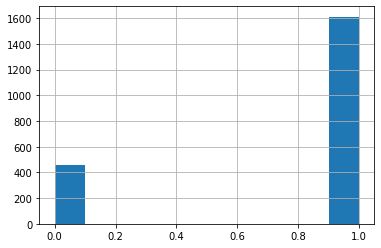

In [96]:
fasta_df['index'] = fasta_df.index
fasta_df=fasta_df[~fasta_df['sequence'].str.contains('X')]
fasta_df=fasta_df[~fasta_df['sequence'].str.contains('B')]
fasta_df=fasta_df[~fasta_df['sequence'].str.contains('-')]
fasta_df=fasta_df[~fasta_df['sequence'].str.contains('Z')]

fasta_df['uptake_type'].hist()

Поскольку в исходном датасете класс CPP перепредставлен по сравнению с классом non-CPP, необходимо обогатить данные пептидами класса non-CPP

В качестве таких пептидов были использованы случайные пептиды тех же длин, что и пептиды в датасете, взятые из белковых последовательностей протеома человека (https://www.uniprot.org/proteomes/UP000005640)

Кажется разумным предположить, что белки протеома человека не обладают способностью проникать через мембраны клеток, а значит не содержат в своем составе CPP

In [97]:
#нужно добавить сэмплы в класс 0
#случайные пептиды из человеческого протеома, соответствующие по длине CPP
random_human_df = pd.read_csv('random_human.csv')
random_human_df = random_human_df.drop('Unnamed: 0', axis=1)
random_human_df.head()

uptake_type 
 sequence 
 
 
 
 
 0 
 0 
 GTRTDSREDEI 
 
 
 1 
 0 
 VLPAWQGYHPM 
 
 
 2 
 0 
 AQPLWGLLSFLPL 
 
 
 3 
 0 
 LPLESGNCAPF 
 
 
 4 
 0 
 LFWLGWLGML

In [98]:
random_human_df=random_human_df[~random_human_df['sequence'].str.contains('X')]
random_human_df = random_human_df.drop_duplicates()

<Axes: >

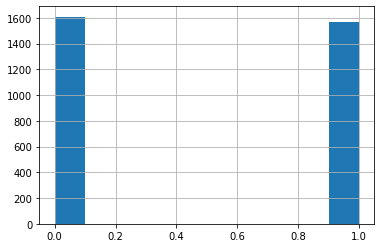

In [99]:
### MERGE TIM'S ADDITIONAL DATA
enriched_binary_df=pd.concat([random_human_df, pep_df])
enriched_binary_df['uptake_type'].hist()

In [100]:
len(enriched_binary_df)

3172

In [101]:
enriched_binary_df[~enriched_binary_df.sequence.str.contains(valid_pattern, regex=True)]

uptake_type 
 sequence 
 
 
 
 
 62 
 1 
 EEEEEEEEEE-PLGLAG-VSRRRRRRGGRRRR 
 
 
 204 
 1 
 ISF-R8-ELLDYY-S5-ESGS 
 
 
 205 
 1 
 ISF-R8-ELLDYY-S5-ED 
 
 
 206 
 1 
 ISF-R8-EWLQAY-S5-EDE 
 
 
 207 
 1 
 PKKKRKV-AGYLLGKINLKALAALAKKIL-PQMQQNVFQYPGAGMV... 
 
 
 208 
 1 
 PKKKRKV-RRRRRRR-YSQTSHKLVQLLTTAEQQ 
 
 
 209 
 1 
 PKKKRKV-AGYLLGKINLKALAALAKKIL-PQMQQNVFQYPGAGMV... 
 
 
 210 
 1 
 PKKKRKV-RRRRRRR-PQMQQNVFQYPGAGMVPQGEANF 
 
 
 234 
 1 
 RGDfK 
 
 
 270 
 1 
 CREKA-KKLFKKILKKL 
 
 
 272 
 1 
 CREKA-KKLFKKILKKL 
 
 
 325 
 1 
 WELVVLGKL-YGRKKRRQRRR 
 
 
 326 
 1 
 ELVVLGKL-YGRKKRRQRRR 
 
 
 327 
 1 
 LVVLGKL-YGRKKRRQRRR 
 
 
 328 
 1 
 VVLGKL-YGRKKRRQRRR 
 
 
 329 
 1 
 WELVVLGK-YGRKKRRQRRR 
 
 
 330 
 1 
 WELVVLG-YGRKKRRQRRR 
 
 
 331 
 1 
 WELVVL-YGRKKRRQRRR 
 
 
 332 
 1 
 WELVV-YGRKKRRQRRR 
 
 
 333 
 1 
 WELV-YGRKKRRQRRR 
 
 
 334 
 1 
 WEL-YGRKKRRQRRR 
 
 
 335 
 1 
 WE-YGRKKRRQRRR 
 
 
 336 
 1 
 WELVVA-YGRKKRRQRRR 
 
 
 337 
 1 
 WEAVVL-YGRKKRRQRRR 
 
 
 338 
 1 
 WEAVVA-YGRKKRRQRRR 
 
 
 339 
 1 
 Ac-WELVVL-YGRKKRRQRRR 
 
 
 374 
 1 
 HEHEHEHEHE-PEG-PLA 
 
 
 375 
 1 
 RGRGRGRGRG-PEG-PLA 
 
 
 376 
 1 
 mPEG-PLA-HEHEHEHEHE 
 
 
 377 
 1 
 mPEG-PLA-RGRGRGRGRG 
 
 
 450 
 1 
 YGRKKRRQRRR-C 
 
 
 500 
 1 
 RRRRRRRR-RGD 
 
 
 533 
 1 
 CGRKKRRQRR-Ahx-RPPQ 
 
 
 534 
 1 
 CGRKKR-Ahx-RQRRRPPQ 
 
 
 535 
 1 
 CGRKKRRQR-Ahx-RRPPQ 
 
 
 536 
 1 
 CGRKKR-Ahx-RQR-Ahx-R-ahx-RPPQ 
 
 
 588 
 1 
 CGNVVRQGC-G-YGRK-KRRQRRR-G-TALDWSWLQTE 
 
 
 625 
 1 
 CALNN-YGRKKRRQRRR 
 
 
 655 
 1 
 GRKKRRERRRPPERKCX 
 
 
 779 
 1 
 Biotin(O)-GGGG-RRWWRRWRR 
 
 
 780 
 1 
 Biotin(O)-GGGG-RRFFRRFRR 
 
 
 781 
 1 
 Biotin(O)-GGGG-RRFFRRWRR 
 
 
 782 
 1 
 Biotin(O)-GGGG-RRWFRRFRR 
 
 
 783 
 1 
 Biotin(O)-GGGG-RRFWRRFRR 
 
 
 784 
 1 
 Biotin(O)-GGGG-RRFWRRWRR 
 
 
 785 
 1 
 Biotin(O)-GGGG-RRWWRRFRR 
 
 
 786 
 1 
 Biotin(O)-GGGG-RRWFRRWRR 
 
 
 1143 
 1 
 SQMTRQARRLYBGC 
 
 
 1263 
 1 
 YKQCHKKGGXKKGSG 
 
 
 1398 
 1 
 HGWZIHGLLHRA 
 
 
 1399 
 1 
 AVPAKKRZKSV

In [102]:
def find_biotin_o(sequence):
    """
    Finds sequences starting with Biotin(O)- and creates a categorical feature `biotin_o`.
    Returns 1 if it starts with Biotin(O)-, otherwise 0.
    """
    pattern = r'^Biotin\(O\)-'
    return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0

In [103]:
def clean_sequence_biotin_o(sequence):
    """
    Removes sequences starting with Biotin(O)- and ensures the remaining sequence matches valid_pattern.
    """
    valid_pattern = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
    if pd.notnull(sequence) and sequence.startswith('Biotin(O)-'):
        cleaned_sequence = sequence[10:]  # Remove 'Biotin(O)-'
        if re.match(valid_pattern, cleaned_sequence):
            return cleaned_sequence
    return sequence

In [104]:
# Apply the function to create the 'biotin_o' categorical feature
enriched_binary_df['biotin_o'] = enriched_binary_df['sequence'].apply(find_biotin_o)

# Apply the function to clean the sequences
enriched_binary_df['sequence'] = enriched_binary_df['sequence'].apply(clean_sequence_biotin_o)

In [105]:
check_valid_ratio(enriched_binary_df, 'sequence')

Percentage of fully valid sequences: 98.39 %


In [106]:
enriched_binary_df = enriched_binary_df[enriched_binary_df.sequence.str.contains(valid_pattern, regex=True)]

### Export clean data

In [104]:
check_valid_ratio(enriched_binary_df, 'sequence')

Percentage of fully valid sequences: 100.00 %


In [105]:
enriched_binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3121 entries, 0 to 1563
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uptake_type  3121 non-null   int64 
 1   sequence     3121 non-null   object
 2   biotin_o     3121 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 97.5+ KB


In [106]:
len(enriched_binary_df)

3121

In [107]:
check_valid_ratio(poseidon_no_conc_drop_nan, 'cleaned_sequence')

Percentage of fully valid sequences: 100.00 %


In [108]:
poseidon_no_conc_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524 entries, 0 to 2094
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Peptide            1524 non-null   object 
 1   Cell line          1524 non-null   object 
 2   Cargo              1524 non-null   object 
 3   PubmedID           1524 non-null   int64  
 4   Uptake             1524 non-null   object 
 5   Units              1524 non-null   object 
 6   Time               1524 non-null   float64
 7   Temp.              1524 non-null   float64
 8   Method             1524 non-null   object 
 9   Type               1524 non-null   object 
 10  Sequence           1524 non-null   object 
 11  new_uptake         1524 non-null   float64
 12  nht_tail           1524 non-null   int64  
 13  acylated_terminal  1524 non-null   int64  
 14  cleaned_sequence   1524 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 190.5+ KB


In [109]:
len(poseidon_no_conc_drop_nan)

1524

In [110]:
check_valid_ratio(poseidon_df_drop_nan, 'cleaned_sequence')

Percentage of fully valid sequences: 100.00 %


In [111]:
poseidon_df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823 entries, 0 to 2038
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Peptide            823 non-null    object 
 1   Cell line          823 non-null    object 
 2   Cargo              823 non-null    object 
 3   PubmedID           823 non-null    int64  
 4   Uptake             823 non-null    object 
 5   Units              823 non-null    object 
 6   Conc.              823 non-null    object 
 7   Time               823 non-null    float64
 8   Temp.              823 non-null    float64
 9   Method             823 non-null    object 
 10  Type               823 non-null    object 
 11  Sequence           823 non-null    object 
 12  Conc. (uM)         823 non-null    float64
 13  new_uptake         823 non-null    float64
 14  nht_tail           823 non-null    int64  
 15  acylated_terminal  823 non-null    int64  
 16  cleaned_sequence   823 no

In [112]:
len(poseidon_df_drop_nan)

823

In [113]:
# EXPORT 3 DATASETS
enriched_binary_df.to_csv('binary_preprocessed.csv')
poseidon_no_conc_drop_nan.to_csv('large_no_conc_preprocessed.csv')
poseidon_df_drop_nan.to_csv('small_preprocessed.csv')

# Basic feature engineering

### Biopython

In [109]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from PyBioMed.PyProtein import CTD

In [110]:
def calculate_protein_descriptors(sequence):
    analysis = ProteinAnalysis(sequence)

    descriptors = {
        'molecular_weight': analysis.molecular_weight(),
        'aromaticity': analysis.aromaticity(),
        'instability_index': analysis.instability_index(),
        'isoelectric_point': analysis.isoelectric_point(),
        'helix_fraction': analysis.secondary_structure_fraction()[0],
        'turn_fraction': analysis.secondary_structure_fraction()[1],
        'sheet_fraction': analysis.secondary_structure_fraction()[2],
        'molar_extinction_coefficient_reduced': analysis.molar_extinction_coefficient()[0],
        'molar_extinction_coefficient_oxidized': analysis.molar_extinction_coefficient()[1],
        'gravy': analysis.gravy(),
        'sequence':sequence
    }
    
    return pd.Series(descriptors)

In [111]:
# fasta_df=fasta_df[~fasta_df['sequence'].str.contains('X')]
# fasta_df=fasta_df[~fasta_df['sequence'].str.contains('B')]
# fasta_df=fasta_df[~fasta_df['sequence'].str.contains('-')]
# fasta_df=fasta_df[~fasta_df['sequence'].str.contains('Z')]
# NOT ACTUAL, BECAUSE SEQUENCES ARE ALREADY CLEAN

fasta_df_descriptors=enriched_binary_df.copy()
fasta_df_descriptors = enriched_binary_df['sequence'].apply(calculate_protein_descriptors)
fasta_df_descriptors

molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 
 
 
 
 0 
 1278.2835 
 0.000000 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 GTRTDSREDEI 
 
 
 1 
 1298.5111 
 0.181818 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 VLPAWQGYHPM 
 
 
 2 
 1454.7531 
 0.153846 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 AQPLWGLLSFLPL 
 
 
 3 
 1147.3007 
 0.090909 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 LPLESGNCAPF 
 
 
 4 
 1235.5379 
 0.300000 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 LFWLGWLGML 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1559 
 3429.9483 
 0.000000 
 134.914286 
 11.910421 
 0.357143 
 0.178571 
 0.142857 
 0 
 0 
 -1.935714 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 
 
 1560 
 2789.3795 
 0.086957 
 87.843478 
 11.999968 
 0.434783 
 0.086957 
 0.391304 
 11000 
 11000 
 -0.169565 
 WLRRIKAWLRRIKALNRQLGVAA 
 
 
 1561 
 1590.8850 
 0.000000 
 227.683333 
 11.999968 
 0.166667 
 0.250000 
 0.000000 
 0 
 0 
 -3.491667 
 GRKKRRQRRRPP 
 
 
 1562 
 1423.6866 
 0.000000 
 518.044444 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRRR 
 
 
 1563 
 1267.5009 
 0.000000 
 509.950000 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRR 
 
 
 
 3121 rows × 11 columns

In [112]:
def calculate_charge_at_pH(row, seq_col_name = 'sequence'):
    analysis = ProteinAnalysis(row['sequence'])
    return analysis.charge_at_pH(7.0)

In [113]:
enriched_binary_df = enriched_binary_df.reset_index(drop=True) 

In [114]:
fasta_df_descriptors = fasta_df_descriptors.reset_index(drop=True)

In [115]:
fasta_df_descriptors['charge_at_ph'] = enriched_binary_df.apply(calculate_charge_at_pH, axis=1)

In [116]:
fasta_df_descriptors

molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 
 
 
 
 0 
 1278.2835 
 0.000000 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 GTRTDSREDEI 
 -2.232056 
 
 
 1 
 1298.5111 
 0.181818 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 VLPAWQGYHPM 
 -0.179836 
 
 
 2 
 1454.7531 
 0.153846 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 AQPLWGLLSFLPL 
 -0.204125 
 
 
 3 
 1147.3007 
 0.090909 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 LPLESGNCAPF 
 -1.246989 
 
 
 4 
 1235.5379 
 0.300000 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 LFWLGWLGML 
 -0.239898 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 3429.9483 
 0.000000 
 134.914286 
 11.910421 
 0.357143 
 0.178571 
 0.142857 
 0 
 0 
 -1.935714 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 8.753855 
 
 
 3117 
 2789.3795 
 0.086957 
 87.843478 
 11.999968 
 0.434783 
 0.086957 
 0.391304 
 11000 
 11000 
 -0.169565 
 WLRRIKAWLRRIKALNRQLGVAA 
 6.758054 
 
 
 3118 
 1590.8850 
 0.000000 
 227.683333 
 11.999968 
 0.166667 
 0.250000 
 0.000000 
 0 
 0 
 -3.491667 
 GRKKRRQRRRPP 
 7.758044 
 
 
 3119 
 1423.6866 
 0.000000 
 518.044444 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRRR 
 8.760012 
 
 
 3120 
 1267.5009 
 0.000000 
 509.950000 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRR 
 7.760022 
 
 
 
 3121 rows × 12 columns

In [117]:
fasta_df_descriptors = fasta_df_descriptors.reset_index(drop=True)
fasta_df = fasta_df.reset_index(drop=True)

In [118]:
fasta_df_descriptors

molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 
 
 
 
 0 
 1278.2835 
 0.000000 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 GTRTDSREDEI 
 -2.232056 
 
 
 1 
 1298.5111 
 0.181818 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 VLPAWQGYHPM 
 -0.179836 
 
 
 2 
 1454.7531 
 0.153846 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 AQPLWGLLSFLPL 
 -0.204125 
 
 
 3 
 1147.3007 
 0.090909 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 LPLESGNCAPF 
 -1.246989 
 
 
 4 
 1235.5379 
 0.300000 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 LFWLGWLGML 
 -0.239898 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 3429.9483 
 0.000000 
 134.914286 
 11.910421 
 0.357143 
 0.178571 
 0.142857 
 0 
 0 
 -1.935714 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 8.753855 
 
 
 3117 
 2789.3795 
 0.086957 
 87.843478 
 11.999968 
 0.434783 
 0.086957 
 0.391304 
 11000 
 11000 
 -0.169565 
 WLRRIKAWLRRIKALNRQLGVAA 
 6.758054 
 
 
 3118 
 1590.8850 
 0.000000 
 227.683333 
 11.999968 
 0.166667 
 0.250000 
 0.000000 
 0 
 0 
 -3.491667 
 GRKKRRQRRRPP 
 7.758044 
 
 
 3119 
 1423.6866 
 0.000000 
 518.044444 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRRR 
 8.760012 
 
 
 3120 
 1267.5009 
 0.000000 
 509.950000 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRR 
 7.760022 
 
 
 
 3121 rows × 12 columns

In [119]:
full_fasta_df_descriptors = pd.concat([fasta_df_descriptors,fasta_df['uptake_type']],axis=1)
full_fasta_df_descriptors

molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 uptake_type 
 
 
 
 
 0 
 1278.2835 
 0.000000 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 GTRTDSREDEI 
 -2.232056 
 0.0 
 
 
 1 
 1298.5111 
 0.181818 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 VLPAWQGYHPM 
 -0.179836 
 0.0 
 
 
 2 
 1454.7531 
 0.153846 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 AQPLWGLLSFLPL 
 -0.204125 
 0.0 
 
 
 3 
 1147.3007 
 0.090909 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 LPLESGNCAPF 
 -1.246989 
 0.0 
 
 
 4 
 1235.5379 
 0.300000 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 LFWLGWLGML 
 -0.239898 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 3429.9483 
 0.000000 
 134.914286 
 11.910421 
 0.357143 
 0.178571 
 0.142857 
 0 
 0 
 -1.935714 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 8.753855 
 NaN 
 
 
 3117 
 2789.3795 
 0.086957 
 87.843478 
 11.999968 
 0.434783 
 0.086957 
 0.391304 
 11000 
 11000 
 -0.169565 
 WLRRIKAWLRRIKALNRQLGVAA 
 6.758054 
 NaN 
 
 
 3118 
 1590.8850 
 0.000000 
 227.683333 
 11.999968 
 0.166667 
 0.250000 
 0.000000 
 0 
 0 
 -3.491667 
 GRKKRRQRRRPP 
 7.758044 
 NaN 
 
 
 3119 
 1423.6866 
 0.000000 
 518.044444 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRRR 
 8.760012 
 NaN 
 
 
 3120 
 1267.5009 
 0.000000 
 509.950000 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 RRRRRRRR 
 7.760022 
 NaN 
 
 
 
 3121 rows × 13 columns

In [120]:
poseidon_df_drop_nan_descriptors = poseidon_df_drop_nan.cleaned_sequence.apply(calculate_protein_descriptors)
poseidon_no_conc_drop_nan_descriptors = poseidon_no_conc_drop_nan.cleaned_sequence.apply(calculate_protein_descriptors)

In [121]:
poseidon_df_drop_nan_descriptors['charge_at_ph'] = poseidon_df_drop_nan_descriptors.apply(
    lambda row: calculate_charge_at_pH(row, 'cleaned_sequence'), axis=1
)
poseidon_df_drop_nan_descriptors=pd.concat([poseidon_df_drop_nan_descriptors,poseidon_df_drop_nan['new_uptake']],axis=1)
print(len(poseidon_df_drop_nan_descriptors))
poseidon_df_drop_nan_descriptors.head()

823


molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 new_uptake 
 
 
 
 
 0 
 1339.6033 
 0.0 
 257.444444 
 11.999968 
 0.222222 
 0.0 
 0.0 
 0 
 0 
 -4.255556 
 RKKRRQRRR 
 7.758044 
 650.00 
 
 
 1 
 1183.4176 
 0.0 
 216.775000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 RKKRRQRR 
 6.758054 
 31.25 
 
 
 2 
 1027.2319 
 0.0 
 164.485714 
 11.999968 
 0.285714 
 0.0 
 0.0 
 0 
 0 
 -4.185714 
 RKKRRQR 
 5.758064 
 10.00 
 
 
 3 
 1183.4176 
 0.0 
 288.375000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 KKRRQRRR 
 6.758054 
 22.50 
 
 
 4 
 1055.2453 
 0.0 
 328.142857 
 11.999968 
 0.142857 
 0.0 
 0.0 
 0 
 0 
 -4.271429 
 KRRQRRR 
 5.759053 
 20.00

In [122]:
poseidon_no_conc_drop_nan_descriptors['charge_at_ph'] = poseidon_no_conc_drop_nan_descriptors.apply(
    lambda row: calculate_charge_at_pH(row, 'cleaned_sequence'), axis=1
)
print(len(poseidon_no_conc_drop_nan_descriptors))
poseidon_no_conc_drop_nan_descriptors.head()

1524


molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 
 
 
 
 0 
 1339.6033 
 0.0 
 257.444444 
 11.999968 
 0.222222 
 0.0 
 0.0 
 0 
 0 
 -4.255556 
 RKKRRQRRR 
 7.758044 
 
 
 1 
 1183.4176 
 0.0 
 216.775000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 RKKRRQRR 
 6.758054 
 
 
 2 
 1027.2319 
 0.0 
 164.485714 
 11.999968 
 0.285714 
 0.0 
 0.0 
 0 
 0 
 -4.185714 
 RKKRRQR 
 5.758064 
 
 
 3 
 1183.4176 
 0.0 
 288.375000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 KKRRQRRR 
 6.758054 
 
 
 4 
 1055.2453 
 0.0 
 328.142857 
 11.999968 
 0.142857 
 0.0 
 0.0 
 0 
 0 
 -4.271429 
 KRRQRRR 
 5.759053

### PyBioMed

##### Binary df

In [123]:
from PyBioMed.PyProtein import CTD

def pybiomed_proteinCT(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return a

new_cols = list(pybiomed_proteinCT('AAA').keys())
def pybiomed_proteinCT2(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return [seq]+list(a.values())

len(pybiomed_proteinCT2('AAA'))
pybiomed_df = fasta_df.copy()

prottups = enriched_binary_df['sequence'].apply(pybiomed_proteinCT2)
pybiomed_prot_df = pd.DataFrame(prottups.to_list(), columns=['sequence']+new_cols)
pybiomed_prot_df


sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 _ChargeT23 
 _PolarityT12 
 _PolarityT13 
 _PolarityT23 
 _NormalizedVDWVT12 
 _NormalizedVDWVT13 
 _NormalizedVDWVT23 
 _HydrophobicityT12 
 _HydrophobicityT13 
 _HydrophobicityT23 
 
 
 
 
 0 
 GTRTDSREDEI 
 0.545 
 0.273 
 0.182 
 0.182 
 0.545 
 0.273 
 0.364 
 0.273 
 0.364 
 ... 
 0.300 
 0.100 
 0.000 
 0.100 
 0.200 
 0.300 
 0.100 
 0.500 
 0.100 
 0.000 
 
 
 1 
 VLPAWQGYHPM 
 0.182 
 0.455 
 0.364 
 0.455 
 0.091 
 0.455 
 0.455 
 0.273 
 0.273 
 ... 
 0.000 
 0.300 
 0.100 
 0.100 
 0.200 
 0.400 
 0.100 
 0.100 
 0.100 
 0.300 
 
 
 2 
 AQPLWGLLSFLPL 
 0.231 
 0.615 
 0.154 
 0.692 
 0.077 
 0.231 
 0.538 
 0.154 
 0.308 
 ... 
 0.000 
 0.250 
 0.000 
 0.000 
 0.583 
 0.167 
 0.167 
 0.167 
 0.000 
 0.583 
 
 
 3 
 LPLESGNCAPF 
 0.273 
 0.636 
 0.091 
 0.545 
 0.182 
 0.273 
 0.364 
 0.182 
 0.455 
 ... 
 0.200 
 0.500 
 0.000 
 0.000 
 0.400 
 0.100 
 0.000 
 0.200 
 0.200 
 0.400 
 
 
 4 
 LFWLGWLGML 
 0.200 
 0.400 
 0.400 
 0.900 
 0.000 
 0.100 
 0.500 
 0.300 
 0.200 
 ... 
 0.000 
 0.000 
 0.000 
 0.000 
 0.222 
 0.222 
 0.444 
 0.000 
 0.000 
 0.444 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 0.286 
 0.250 
 0.464 
 0.250 
 0.607 
 0.143 
 0.679 
 0.143 
 0.179 
 ... 
 0.111 
 0.037 
 0.111 
 0.259 
 0.037 
 0.148 
 0.333 
 0.185 
 0.148 
 0.111 
 
 
 3117 
 WLRRIKAWLRRIKALNRQLGVAA 
 0.217 
 0.391 
 0.391 
 0.609 
 0.391 
 0.000 
 0.696 
 0.217 
 0.087 
 ... 
 0.000 
 0.091 
 0.273 
 0.091 
 0.182 
 0.136 
 0.455 
 0.091 
 0.364 
 0.227 
 
 
 3118 
 GRKKRRQRRRPP 
 0.083 
 0.250 
 0.667 
 0.083 
 0.750 
 0.167 
 0.750 
 0.000 
 0.250 
 ... 
 0.000 
 0.000 
 0.000 
 0.273 
 0.000 
 0.182 
 0.182 
 0.182 
 0.000 
 0.000 
 
 
 3119 
 RRRRRRRRR 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 ... 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 
 
 3120 
 RRRRRRRR 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 ... 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 
 
 
 3121 rows × 43 columns

In [124]:
fasta_df_descriptors.index

RangeIndex(start=0, stop=3121, step=1)

In [125]:
fasta_df_descriptors = fasta_df_descriptors.reset_index().drop(columns=['index'])

In [126]:
pybiomed_prot_df.index

RangeIndex(start=0, stop=3121, step=1)

In [127]:
pybiomed_prot_df = pybiomed_prot_df.reset_index().drop(columns=['index'])

In [128]:
print(pybiomed_prot_df.index, fasta_df_descriptors.index)

RangeIndex(start=0, stop=3121, step=1) RangeIndex(start=0, stop=3121, step=1)


In [129]:
new_full_fasta_df_descriptors=pd.concat([pybiomed_prot_df, fasta_df_descriptors], axis = 1)
print(len(new_full_fasta_df_descriptors))
new_full_fasta_df_descriptors.head()

3121


sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 
 
 
 
 0 
 GTRTDSREDEI 
 0.545 
 0.273 
 0.182 
 0.182 
 0.545 
 0.273 
 0.364 
 0.273 
 0.364 
 ... 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 GTRTDSREDEI 
 -2.232056 
 
 
 1 
 VLPAWQGYHPM 
 0.182 
 0.455 
 0.364 
 0.455 
 0.091 
 0.455 
 0.455 
 0.273 
 0.273 
 ... 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 VLPAWQGYHPM 
 -0.179836 
 
 
 2 
 AQPLWGLLSFLPL 
 0.231 
 0.615 
 0.154 
 0.692 
 0.077 
 0.231 
 0.538 
 0.154 
 0.308 
 ... 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 AQPLWGLLSFLPL 
 -0.204125 
 
 
 3 
 LPLESGNCAPF 
 0.273 
 0.636 
 0.091 
 0.545 
 0.182 
 0.273 
 0.364 
 0.182 
 0.455 
 ... 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 LPLESGNCAPF 
 -1.246989 
 
 
 4 
 LFWLGWLGML 
 0.200 
 0.400 
 0.400 
 0.900 
 0.000 
 0.100 
 0.500 
 0.300 
 0.200 
 ... 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 LFWLGWLGML 
 -0.239898 
 
 
 
 5 rows × 55 columns

In [130]:
new_full_fasta_df_descriptors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3121 entries, 0 to 3120
Data columns (total 55 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   sequence                               3121 non-null   object 
 1   _PolarizabilityC1                      3121 non-null   float64
 2   _PolarizabilityC2                      3121 non-null   float64
 3   _PolarizabilityC3                      3121 non-null   float64
 4   _SolventAccessibilityC1                3121 non-null   float64
 5   _SolventAccessibilityC2                3121 non-null   float64
 6   _SolventAccessibilityC3                3121 non-null   float64
 7   _SecondaryStrC1                        3121 non-null   float64
 8   _SecondaryStrC2                        3121 non-null   float64
 9   _SecondaryStrC3                        3121 non-null   float64
 10  _ChargeC1                              3121 non-null   float64
 11  _Cha

##### No conc df

In [131]:
len(poseidon_no_conc_drop_nan)

1524

In [132]:
prottups = poseidon_no_conc_drop_nan['cleaned_sequence'].apply(pybiomed_proteinCT2)
pybiomed_prot_df = pd.DataFrame(prottups.to_list(), columns=['cleaned_sequence']+new_cols)
pybiomed_prot_df.head()

cleaned_sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 _ChargeT23 
 _PolarityT12 
 _PolarityT13 
 _PolarityT23 
 _NormalizedVDWVT12 
 _NormalizedVDWVT13 
 _NormalizedVDWVT23 
 _HydrophobicityT12 
 _HydrophobicityT13 
 _HydrophobicityT23 
 
 
 
 
 0 
 RKKRRQRRR 
 0.0 
 0.111 
 0.889 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.250 
 0.0 
 0.0 
 0.250 
 0.0 
 0.0 
 0.0 
 
 
 1 
 RKKRRQRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.0 
 
 
 2 
 RKKRRQR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.0 
 
 
 3 
 KKRRQRRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.0 
 
 
 4 
 KRRQRRR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.0 
 
 
 
 5 rows × 43 columns

In [133]:
full_poseidon_no_conc_drop_nan = pd.concat([
    pybiomed_prot_df.reset_index().drop(columns=['index']),
    poseidon_no_conc_drop_nan_descriptors.reset_index().drop(columns=['index'])
], axis = 1, ignore_index=False)
print(len(full_poseidon_no_conc_drop_nan))

1524


In [134]:
full_poseidon_no_conc_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 55 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   cleaned_sequence                       1524 non-null   object 
 1   _PolarizabilityC1                      1524 non-null   float64
 2   _PolarizabilityC2                      1524 non-null   float64
 3   _PolarizabilityC3                      1524 non-null   float64
 4   _SolventAccessibilityC1                1524 non-null   float64
 5   _SolventAccessibilityC2                1524 non-null   float64
 6   _SolventAccessibilityC3                1524 non-null   float64
 7   _SecondaryStrC1                        1524 non-null   float64
 8   _SecondaryStrC2                        1524 non-null   float64
 9   _SecondaryStrC3                        1524 non-null   float64
 10  _ChargeC1                              1524 non-null   float64
 11  _Cha

##### Conc df

In [135]:
prottups = poseidon_df_drop_nan['cleaned_sequence'].apply(pybiomed_proteinCT2)
pybiomed_prot_df = pd.DataFrame(prottups.to_list(), columns=['cleaned_sequence']+new_cols)
pybiomed_prot_df.head()

cleaned_sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 _ChargeT23 
 _PolarityT12 
 _PolarityT13 
 _PolarityT23 
 _NormalizedVDWVT12 
 _NormalizedVDWVT13 
 _NormalizedVDWVT23 
 _HydrophobicityT12 
 _HydrophobicityT13 
 _HydrophobicityT23 
 
 
 
 
 0 
 RKKRRQRRR 
 0.0 
 0.111 
 0.889 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.250 
 0.0 
 0.0 
 0.250 
 0.0 
 0.0 
 0.0 
 
 
 1 
 RKKRRQRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.0 
 
 
 2 
 RKKRRQR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.0 
 
 
 3 
 KKRRQRRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.286 
 0.0 
 0.0 
 0.0 
 
 
 4 
 KRRQRRR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.333 
 0.0 
 0.0 
 0.0 
 
 
 
 5 rows × 43 columns

In [136]:
full_poseidon_df_drop_nan = pd.concat([
    pybiomed_prot_df.reset_index().drop(columns='index'),
    poseidon_df_drop_nan.reset_index().drop(columns='index')
], axis = 1)
print(len(full_poseidon_df_drop_nan))

823


In [137]:
full_poseidon_df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cleaned_sequence          823 non-null    object 
 1   _PolarizabilityC1         823 non-null    float64
 2   _PolarizabilityC2         823 non-null    float64
 3   _PolarizabilityC3         823 non-null    float64
 4   _SolventAccessibilityC1   823 non-null    float64
 5   _SolventAccessibilityC2   823 non-null    float64
 6   _SolventAccessibilityC3   823 non-null    float64
 7   _SecondaryStrC1           823 non-null    float64
 8   _SecondaryStrC2           823 non-null    float64
 9   _SecondaryStrC3           823 non-null    float64
 10  _ChargeC1                 823 non-null    float64
 11  _ChargeC2                 823 non-null    float64
 12  _ChargeC3                 823 non-null    float64
 13  _PolarityC1               823 non-null    float64
 14  _PolarityC

In [138]:
len(full_poseidon_df_drop_nan)

823

In [139]:
new_full_fasta_df_descriptors = new_full_fasta_df_descriptors.loc[:,~new_full_fasta_df_descriptors.columns.duplicated()]
full_poseidon_df_drop_nan = full_poseidon_df_drop_nan.loc[:,~full_poseidon_df_drop_nan.columns.duplicated()]
full_poseidon_no_conc_drop_nan = full_poseidon_no_conc_drop_nan.loc[:,~full_poseidon_no_conc_drop_nan.columns.duplicated()]

In [140]:
full_poseidon_no_conc_drop_nan

cleaned_sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 
 
 
 
 0 
 RKKRRQRRR 
 0.0 
 0.111 
 0.889 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 257.444444 
 11.999968 
 0.222222 
 0.0 
 0.0 
 0 
 0 
 -4.255556 
 RKKRRQRRR 
 7.758044 
 
 
 1 
 RKKRRQRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 216.775000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 RKKRRQRR 
 6.758054 
 
 
 2 
 RKKRRQR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 164.485714 
 11.999968 
 0.285714 
 0.0 
 0.0 
 0 
 0 
 -4.185714 
 RKKRRQR 
 5.758064 
 
 
 3 
 KKRRQRRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 288.375000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 KKRRQRRR 
 6.758054 
 
 
 4 
 KRRQRRR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 328.142857 
 11.999968 
 0.142857 
 0.0 
 0.0 
 0 
 0 
 -4.271429 
 KRRQRRR 
 5.759053 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1519 
 RRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.600 
 0.400 
 1.0 
 0.0 
 0.0 
 ... 
 143.320000 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -3.980000 
 RRHRHRHRHR 
 6.108738 
 
 
 1520 
 RRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.636 
 0.364 
 1.0 
 0.0 
 0.0 
 ... 
 183.272727 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.027273 
 RRRHRHRHRHR 
 7.108728 
 
 
 1521 
 RRRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.667 
 0.333 
 1.0 
 0.0 
 0.0 
 ... 
 216.566667 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.066667 
 RRRRHRHRHRHR 
 8.108718 
 
 
 1522 
 RRRRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.692 
 0.308 
 1.0 
 0.0 
 0.0 
 ... 
 244.738462 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.100000 
 RRRRRHRHRHRHR 
 9.108708 
 
 
 1523 
 CRWRWKCCKK 
 0.0 
 0.300 
 0.700 
 0.5 
 0.500 
 0.000 
 0.5 
 0.5 
 0.0 
 ... 
 123.560000 
 9.898170 
 0.300000 
 0.0 
 0.2 
 11000 
 11125 
 -1.500000 
 CRWRWKCCKK 
 4.727382 
 
 
 
 1524 rows × 55 columns

### Sequence length

In [141]:
new_full_fasta_df_descriptors['sequence_len'] = new_full_fasta_df_descriptors.sequence.str.len()
full_poseidon_df_drop_nan['sequence_len'] = full_poseidon_df_drop_nan.cleaned_sequence.str.len()
full_poseidon_no_conc_drop_nan['sequence_len'] = full_poseidon_no_conc_drop_nan.cleaned_sequence.str.len()

### Export

In [147]:
new_full_fasta_df_descriptors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3121 entries, 0 to 3120
Data columns (total 55 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   sequence                               3121 non-null   object 
 1   _PolarizabilityC1                      3121 non-null   float64
 2   _PolarizabilityC2                      3121 non-null   float64
 3   _PolarizabilityC3                      3121 non-null   float64
 4   _SolventAccessibilityC1                3121 non-null   float64
 5   _SolventAccessibilityC2                3121 non-null   float64
 6   _SolventAccessibilityC3                3121 non-null   float64
 7   _SecondaryStrC1                        3121 non-null   float64
 8   _SecondaryStrC2                        3121 non-null   float64
 9   _SecondaryStrC3                        3121 non-null   float64
 10  _ChargeC1                              3121 non-null   float64
 11  _Cha

In [148]:
full_poseidon_df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cleaned_sequence          823 non-null    object 
 1   _PolarizabilityC1         823 non-null    float64
 2   _PolarizabilityC2         823 non-null    float64
 3   _PolarizabilityC3         823 non-null    float64
 4   _SolventAccessibilityC1   823 non-null    float64
 5   _SolventAccessibilityC2   823 non-null    float64
 6   _SolventAccessibilityC3   823 non-null    float64
 7   _SecondaryStrC1           823 non-null    float64
 8   _SecondaryStrC2           823 non-null    float64
 9   _SecondaryStrC3           823 non-null    float64
 10  _ChargeC1                 823 non-null    float64
 11  _ChargeC2                 823 non-null    float64
 12  _ChargeC3                 823 non-null    float64
 13  _PolarityC1               823 non-null    float64
 14  _PolarityC

In [149]:
full_poseidon_no_conc_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   cleaned_sequence                       1524 non-null   object 
 1   _PolarizabilityC1                      1524 non-null   float64
 2   _PolarizabilityC2                      1524 non-null   float64
 3   _PolarizabilityC3                      1524 non-null   float64
 4   _SolventAccessibilityC1                1524 non-null   float64
 5   _SolventAccessibilityC2                1524 non-null   float64
 6   _SolventAccessibilityC3                1524 non-null   float64
 7   _SecondaryStrC1                        1524 non-null   float64
 8   _SecondaryStrC2                        1524 non-null   float64
 9   _SecondaryStrC3                        1524 non-null   float64
 10  _ChargeC1                              1524 non-null   float64
 11  _Cha

In [150]:
len(full_poseidon_no_conc_drop_nan)

1524

In [151]:
full_poseidon_no_conc_drop_nan = full_poseidon_no_conc_drop_nan.dropna(subset=['cleaned_sequence'])

In [152]:
len(full_poseidon_df_drop_nan)

823

In [153]:
full_poseidon_df_drop_nan = full_poseidon_df_drop_nan.dropna(subset=['cleaned_sequence'])

In [154]:
# EXPORT 3 DATASETS
new_full_fasta_df_descriptors.to_csv('binary_basic_features_.csv')
full_poseidon_df_drop_nan.to_csv('small_basic_features.csv')
full_poseidon_no_conc_drop_nan.to_csv('large_no_conc_basic_features.csv')

In [142]:
BIOPPYTHON_FEATURE_NAMES = list(full_fasta_df_descriptors.drop(columns=['sequence', 'uptake_type']).columns)
BIOPPYTHON_FEATURE_NAMES

['molecular_weight',
 'aromaticity',
 'instability_index',
 'isoelectric_point',
 'helix_fraction',
 'turn_fraction',
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy',
 'charge_at_ph']

# Baseline models

### Correlation analysis

In [164]:
# IMPORT DATASETS
binary_basic_features = pd.read_csv('binary_basic_features_.csv')
small_basic_features = pd.read_csv('small_basic_features.csv')
large_no_conc_basic_features = pd.read_csv('large_no_conc_basic_features.csv')


large_no_conc_preprocessed = pd.read_csv('large_no_conc_preprocessed.csv')
small_preprocessed = pd.read_csv('small_preprocessed.csv')

In [157]:
def find_significant_correlations(df, target_column, correlation_threshold=0.4):
    """
    Функция для нахождения названий столбцов, коррелирующих с указанным таргет-столбцом
    более чем на заданный порог по модулю.

    :param df: pandas DataFrame, содержащий данные
    :param target_column: str, название таргет-столбца
    :param correlation_threshold: float, порог корреляции по модулю (по умолчанию 0.4)
    :return: list, список названий столбцов
    """
    # Рассчитаем корреляционную матрицу
    correlation_matrix = df.corr()

    # Получим корреляции таргет-столбца
    target_correlations = correlation_matrix[target_column]

    # Отфильтруем корреляции по порогу
    significant_correlations = target_correlations[abs(target_correlations) > correlation_threshold]

    # Исключим сам столбец target_column из результата
    significant_correlations = significant_correlations.drop(target_column)

    # Получим названия столбцов
    significant_columns = significant_correlations.index.tolist()

    return significant_columns

#### Classification

In [165]:
# Объединяем датасет фичей с датасетом, содержащий таргет
full_binary_df = pd.concat([
    enriched_binary_df.reset_index().drop(columns='index') ,
    new_full_fasta_df_descriptors.reset_index().drop(columns='index') 
], axis=1, ignore_index=False)

# Убираем дубли столбцов
full_binary_df = full_binary_df.loc[:,~full_binary_df.columns.duplicated()]

<ipython-input-4-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


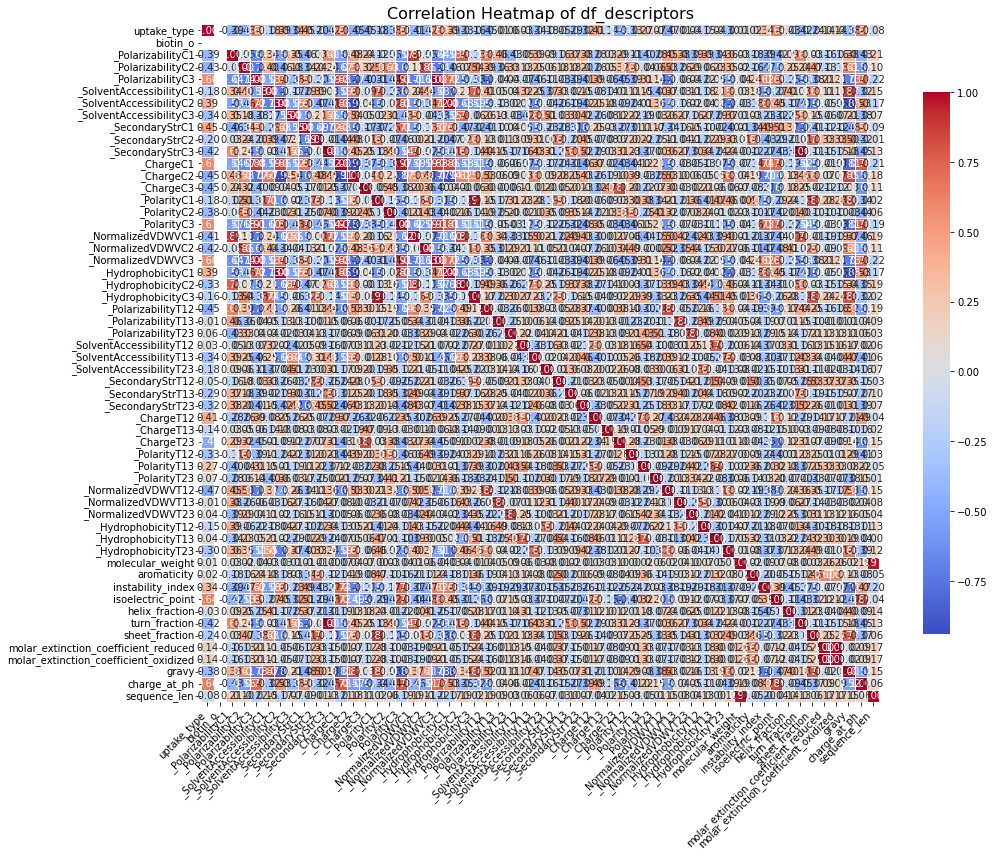

<Figure size 6000x6000 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

In [166]:
draw_heatmap(full_binary_df)
plt.figure(figsize=(30, 30), dpi=200)

In [167]:
full_binary_df.corr()

<ipython-input-167-53221501c9db>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_binary_df.corr()


uptake_type 
 biotin_o 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 ... 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 charge_at_ph 
 sequence_len 
 
 
 
 
 uptake_type 
 1.000000 
 NaN 
 -0.389838 
 -0.431904 
 0.596183 
 -0.184042 
 0.392854 
 -0.340105 
 0.445243 
 -0.203213 
 ... 
 0.340868 
 0.640337 
 -0.029466 
 -0.419170 
 -0.243905 
 0.142491 
 0.142800 
 -0.376135 
 0.658954 
 -0.084581 
 
 
 biotin_o 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 _PolarizabilityC1 
 -0.389838 
 NaN 
 1.000000 
 -0.048496 
 -0.641446 
 0.338506 
 -0.533381 
 0.353997 
 -0.457063 
 0.029983 
 ... 
 -0.393270 
 -0.419671 
 0.085489 
 0.600162 
 0.028594 
 -0.161211 
 -0.160507 
 0.383819 
 -0.430028 
 0.205977 
 
 
 _PolarizabilityC2 
 -0.431904 
 NaN 
 -0.048496 
 1.000000 
 -0.735155 
 0.395817 
 -0.460875 
 0.180331 
 -0.335946 
 0.235796 
 ... 
 -0.465616 
 -0.526511 
 0.254720 
 0.237832 
 0.471762 
 -0.133462 
 -0.132782 
 0.607052 
 -0.558887 
 0.099334 
 
 
 _PolarizabilityC3 
 0.596183 
 NaN 
 -0.641446 
 -0.735155 
 1.000000 
 -0.533787 
 0.715958 
 -0.378683 
 0.568195 
 -0.201393 
 ... 
 0.624532 
 0.689167 
 -0.253705 
 -0.590002 
 -0.381726 
 0.211857 
 0.210856 
 -0.726737 
 0.721047 
 -0.216292 
 
 
 _SolventAccessibilityC1 
 -0.184042 
 NaN 
 0.338506 
 0.395817 
 -0.533787 
 1.000000 
 -0.726910 
 -0.171815 
 -0.286070 
 0.387284 
 ... 
 -0.580311 
 -0.270547 
 0.407480 
 0.025166 
 0.628355 
 0.113178 
 0.114322 
 0.873638 
 -0.315749 
 0.148574 
 
 
 _SolventAccessibilityC2 
 0.392854 
 NaN 
 -0.533381 
 -0.460875 
 0.715958 
 -0.726910 
 1.000000 
 -0.551622 
 0.627849 
 -0.472495 
 ... 
 0.653232 
 0.452708 
 -0.169713 
 -0.414182 
 -0.637119 
 -0.050746 
 -0.051615 
 -0.883915 
 0.529312 
 -0.173081 
 
 
 _SolventAccessibilityC3 
 -0.340105 
 NaN 
 0.353997 
 0.180331 
 -0.378683 
 -0.171815 
 -0.551622 
 1.000000 
 -0.553073 
 0.207277 
 ... 
 -0.232104 
 -0.320738 
 -0.251468 
 0.563535 
 0.150713 
 -0.064902 
 -0.065045 
 0.206855 
 -0.375777 
 0.067559 
 
 
 _SecondaryStrC1 
 0.445243 
 NaN 
 -0.457063 
 -0.335946 
 0.568195 
 -0.286070 
 0.627849 
 -0.553073 
 1.000000 
 -0.686528 
 ... 
 0.494182 
 0.513825 
 0.370582 
 -0.722339 
 -0.409142 
 -0.116319 
 -0.118395 
 -0.478698 
 0.555360 
 -0.087281 
 
 
 _SecondaryStrC2 
 -0.203213 
 NaN 
 0.029983 
 0.235796 
 -0.201393 
 0.387284 
 -0.472495 
 0.207277 
 -0.686528 
 1.000000 
 ... 
 -0.429509 
 -0.286707 
 -0.214908 
 -0.006912 
 0.709114 
 0.328585 
 0.330175 
 0.503147 
 -0.324996 
 -0.005544 
 
 
 _SecondaryStrC3 
 -0.419208 
 NaN 
 0.600215 
 0.237812 
 -0.590023 
 0.025157 
 -0.414206 
 0.563582 
 -0.722289 
 -0.006982 
 ... 
 -0.271074 
 -0.434099 
 -0.305164 
 0.999999 
 -0.111698 
 -0.152771 
 -0.151429 
 0.179882 
 -0.454836 
 0.125167 
 
 
 _ChargeC1 
 0.606116 
 NaN 
 -0.541030 
 -0.670325 
 0.882026 
 -0.587674 
 0.858479 
 -0.517637 
 0.682664 
 -0.441094 
 ... 
 0.737360 
 0.723601 
 -0.194653 
 -0.519427 
 -0.570093 
 -0.010769 
 -0.011408 
 -0.807215 
 0.782069 
 -0.209776 
 
 
 _ChargeC2 
 -0.453563 
 NaN 
 0.478930 
 0.581617 
 -0.771749 
 0.668689 
 -0.939888 
 0.536028 
 -0.657682 
 0.477483 
 ... 
 -0.702790 
 -0.487412 
 0.129110 
 0.450432 
 0.619035 
 0.065243 
 0.065909 
 0.851780 
 -0.570742 
 0.179340 
 
 
 _ChargeC3 
 -0.454635 
 NaN 
 0.235106 
 0.318524 
 -0.404201 
 -0.086526 
 0.041252 
 0.045886 
 -0.173821 
 -0.008651 
 ... 
 -0.205262 
 -0.667188 
 0.184193 
 0.247360 
 -0.015553 
 -0.123592 
 -0.123545 
 0.034881 
 -0.619886 
 0.105735 
 
 
 _PolarityC1 
 -0.179441 
 NaN 
 -0.116030 
 0.508554 
 -0.311839 
 0.711210 
 -0.613252 
 0.015823 
 -0.372615 
 0.679242 
 ... 
 -0.52167

In [189]:
find_significant_correlations(full_binary_df, 'uptake_type')

<ipython-input-184-2cb6e445392d>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


['_PolarizabilityC2',
 '_PolarizabilityC3',
 '_SecondaryStrC1',
 '_SecondaryStrC3',
 '_ChargeC1',
 '_ChargeC2',
 '_ChargeC3',
 '_PolarityC3',
 '_NormalizedVDWVC1',
 '_NormalizedVDWVC2',
 '_NormalizedVDWVC3',
 '_PolarizabilityT12',
 '_ChargeT12',
 '_ChargeT23',
 '_NormalizedVDWVT12',
 'isoelectric_point',
 'turn_fraction',
 'charge_at_ph']

##### Selected feutures

In [190]:
# Отбираем все фичи, у которых корреляция с таргетом выше ~0.4 по модулю
IMPORTANT_FEATURES_BINARY = [
    '_PolarizabilityC2', '_PolarizabilityC2','_SolventAccessibilityC2', '_SecondaryStrC1', '_SecondaryStrC3',
    '_ChargeC1', '_ChargeC2', '_ChargeC3', '_PolarityC3', '_NormalizedVDWVC3', '_PolarizabilityT12', 
    '_ChargeT12', '_ChargeT23', '_NormalizedVDWVT12', 'isoelectric_point', 'turn_fraction', 'charge_at_ph'
]

#### Regression

In [ ]:
small_basic_features = small_basic_features.drop(columns=['Unnamed: 0'])

<ipython-input-4-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


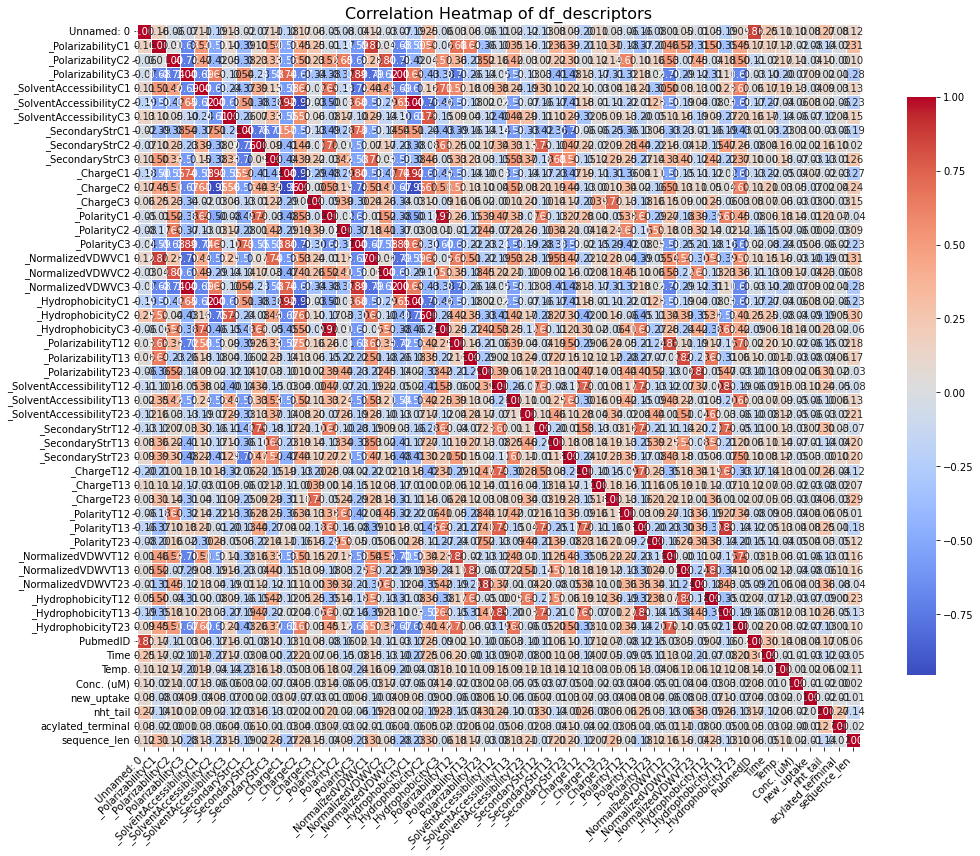

In [221]:
draw_heatmap(small_basic_features)

In [159]:
find_significant_correlations(small_basic_features, 'new_uptake', correlation_threshold=0.1)

<ipython-input-157-2cb6e445392d>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


['_HydrophobicityT13']

In [163]:
small_basic_features['_HydrophobicityT13']

0 0.000
1 0.000
2 0.000
3 0.000
4 0.000
 ... 
818 0.400
819 0.200
820 0.400
821 0.333
822 0.043
Name: _HydrophobicityT13, Length: 823, dtype: float64

In [173]:
# Объединяем датасет фичей с датасетом, содержащий таргет
full_large_no_conc = pd.concat([
    large_no_conc_preprocessed.reset_index().drop(columns='index') ,
    large_no_conc_basic_features.reset_index().drop(columns='index') 
], axis=1, ignore_index=False)

# Убираем дубли столбцов
full_large_no_conc = full_large_no_conc.loc[:,~full_large_no_conc.columns.duplicated()]

full_large_no_conc = full_large_no_conc.drop(columns=['Unnamed: 0'])

<ipython-input-5-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


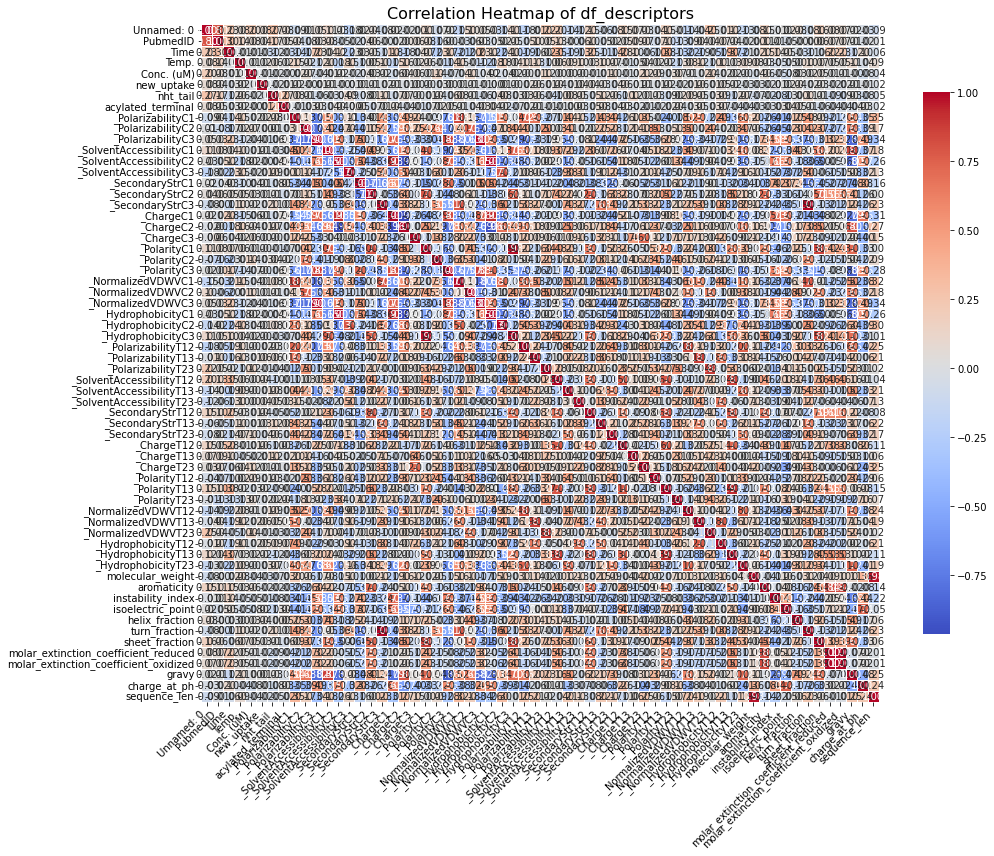

In [176]:
draw_heatmap(full_large_no_conc)

In [180]:
find_significant_correlations(full_large_no_conc, 'new_uptake', correlation_threshold=0.05)

<ipython-input-121-2cb6e445392d>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


['Unnamed: 0', '_PolarizabilityT13', '_ChargeT12', '_NormalizedVDWVT13']

### Export data

In [ ]:
# EXPORT 3 DATASETS

### Classification

In [313]:
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMax, Scaler, LabelEncoder
# ImportError: cannot import name 'MinMax' from 'sklearn.preprocessing' (/opt/python/envs/default/lib/python3.8/site-packages/sklearn/preprocessing/__init__.py)

##### Разбивка на test и train

In [205]:
X_fasta_2 = enriched_binary_df.drop(columns=['uptake_type', 'sequence'])
y_fasta_2 = enriched_binary_df['uptake_type']

In [206]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_fasta_2, y_fasta_2, test_size=0.2, random_state=42)

##### Нормализация данных

In [207]:
# Нормализация числовых данных

# Инициализация MinMaxScaler
scaler = StandardScaler()

# Нормализация для X_1
X_train_4 = scaler.fit_transform(X_train_4)
X_test_4 = scaler.fit_transform(X_test_4)

##### Логистическая регрессия

In [208]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score, f1_score

# Создание объекта модели линейной регрессии
model = LogisticRegression()

# Обучение модели на тренировочной выборке
model.fit(X_train_4, y_train_4)

# Предсказание значений для тестовой выборки
y_pred_4 = model.predict(X_test_4)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_4, y_pred_4)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_4, y_pred_4)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test_4, y_pred_4)
print(f'AUC: {auc}')

# Расчет F1-score
f1 = f1_score(y_test_4, y_pred_4)
print(f'F1 Score: {f1}')

Среднеквадратическая ошибка для тестовой выборки: 0.459
R квадрат для тестовой выборки: -0.849
AUC: 0.5
F1 Score: 0.0


##### Рандомный лес

In [210]:
from sklearn.ensemble import RandomForestClassifier

# Создание объекта модели рандомного леса
model = RandomForestClassifier(
    n_estimators=1000,            # Количество деревьев
    max_depth=7,                # Максимальная глубина деревьев
    min_samples_split=5,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=2,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
model.fit(X_train_4, y_train_4)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test_4)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_4, y_pred_4)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_4, y_pred_4)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test_4, y_pred_4)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test_4, y_pred_4)
print(f'F1 Score: {round(f1, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.459
R квадрат для тестовой выборки: -0.849
AUC: 0.5
F1 Score: 0.0


### Regression

##### Разбивка на train и test

In [211]:
# Разбивка для poseidon_df_drop_nan
final_poseidon_df = poseidon_df_drop_nan[['Peptide', 'Cell line', 'Cargo', 'Units', 'Conc.', 'Temp.', 'Method','Type','Sequence']]

X_1 = final_poseidon_df
y_1 = poseidon_df_drop_nan['new_uptake']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=42)

In [212]:
# Разбивка для poseidon_no_conc_drop_nan
final_poseidon_non_conc = poseidon_no_conc_drop_nan[['Peptide', 'Cell line', 'Cargo', 'Units', 'Conc.', 'Temp.', 'Method','Type','Sequence']]

X_2 = final_poseidon_non_conc
y_2 = poseidon_no_conc_drop_nan['new_uptake']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=0)

##### Нормализация данных

In [213]:
# Нормализация числовых данных

# Инициализация MinMaxScaler
scaler = StandardScaler()

# Нормализация для X_1
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.fit_transform(X_test_1)

ValueError: ValueError: could not convert string to float: 'hClock-(35-47)'

In [ ]:
# Нормализация числовых данных

# Инициализация MinMaxScaler
scaler = StandardScaler()

# Нормализация для X_1
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.fit_transform(X_test_2)

##### Линейная регрессия

Модель для `poseidon_df_drop_nan`

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Создание объекта модели линейной регрессии
model = LinearRegression()

# Обучение модели на тренировочной выборке
model.fit(X_train_1, y_train_1)

# Предсказание значений для тестовой выборки
y_pred_1 = model.predict(X_test_1)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_1, y_pred_1)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_1, y_pred_1)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Модель для `poseidon_no_conc_drop_nan`

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Создание объекта модели линейной регрессии
model = LinearRegression()

# Обучение модели на тренировочной выборке
model.fit(X_train_2, y_train_2)

# Предсказание значений для тестовой выборки
y_pred_2 = model.predict(X_test_2)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_2, y_pred_2)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_2, y_pred_2)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

##### Градиентный бустинг

Модель для `poseidon_df_drop_nan`

In [ ]:
from catboost import CatBoostRegressor

# Создание и обучение модели CatBoost
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=9,
    l2_leaf_reg=0.1,
    loss_function='RMSE',
    verbose=100
)

model.fit(X_train_1, y_train_1)

# Предсказание на тестовой выборке
y_pred_1 = model.predict(X_test_1)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_1, y_pred_1)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_1, y_pred_1)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Модель для `poseidon_no_conc_drop_nan`

In [ ]:
# Создание и обучение модели CatBoost
model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=0.1,
    loss_function='RMSE',
    verbose=100
)

model.fit(X_train_2, y_train_2)

# Предсказание на тестовой выборке
y_pred_2 = model.predict(X_test_2)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_2, y_pred_2)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_2, y_pred_2)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

##### Рандомный лес

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Модель для `poseidon_df_drop_nan`

In [ ]:
# Создание объекта модели рандомного леса
model = RandomForestRegressor(
    n_estimators=500,            # Количество деревьев
    max_depth=10,                # Максимальная глубина деревьев
    min_samples_split=7,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=3,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
model.fit(X_train_1, y_train_1)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test_1)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_1, y_pred_1)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_1, y_pred_1)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Модель для `poseidon_no_conc_drop_nan`

In [ ]:
# Создание объекта модели рандомного леса
best_model = RandomForestRegressor(
    n_estimators=500,            # Количество деревьев
    max_depth=10,                # Максимальная глубина деревьев
    min_samples_split=7,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=3,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
best_model.fit(X_train_2, y_train_2)

# Предсказание значений для тестовой выборки
y_pred_2 = best_model.predict(X_test_2)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test_2, y_pred_2)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test_2, y_pred_2)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# EDA: amino acids and alignment

## Анализ последовательностей

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mean_barplot(data, columns, xlabel, ylabel, title):
    means = data[columns].mean()
    plt.figure(figsize=(10, 6))
    plt.bar(means.index, means.values)
    
    for i, mean in enumerate(means):
        plt.text(i, mean, round(mean, 2), ha='center', va='bottom')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.show()

In [147]:
import pandas as pd

seq_df = enriched_binary_df.copy()

# Получаем уникальные буквы из всех последовательностей
unique_letters = set(''.join(seq_df['sequence']))

# Для каждой уникальной буквы вычисляем процент ее нахождения в каждой последовательности
for letter in unique_letters:
    seq_df[letter] = seq_df['sequence'].apply(lambda x: x.count(letter) / len(x) * 100)

seq_df_good = seq_df[seq_df['uptake_type']==1]
seq_df_bad = seq_df[seq_df['uptake_type']==0]

seq_df.columns

Index(['uptake_type', 'sequence', 'biotin_o', 'G', 'M', 'N', 'E', 'W', 'P',
       'A', 'S', 'R', 'T', 'Y', 'I', 'K', 'L', 'C', 'F', 'Q', 'D', 'H', 'V'],
      dtype='object')

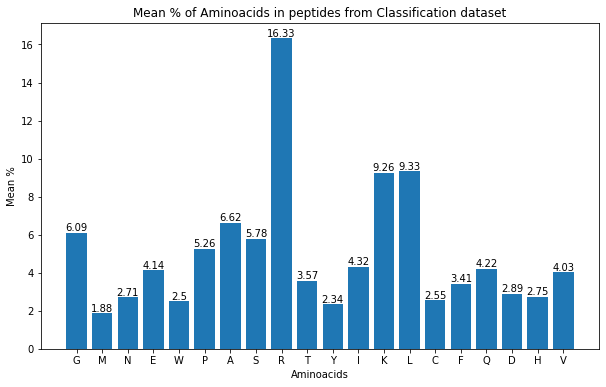

In [149]:
letcols = ['G', 'M', 'N', 'E', 'W', 'P', 'A',
       'S', 'R', 'T', 'Y', 'I', 'K', 'L', 'C', 'F', 'Q', 'D', 'H', 'V']
plot_mean_barplot(seq_df, letcols, xlabel='Aminoacids', ylabel='Mean %', title='Mean % of Aminoacids in peptides from Classification dataset')

## Aminoacid Frequency plot

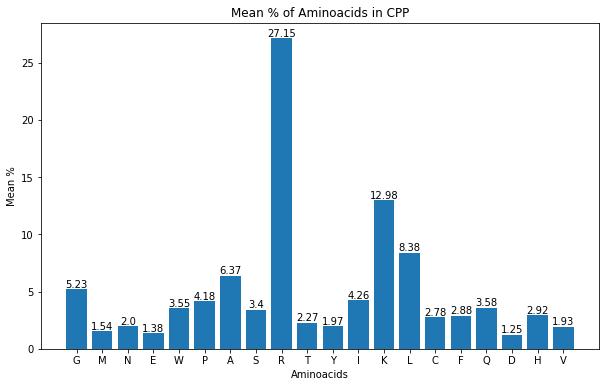

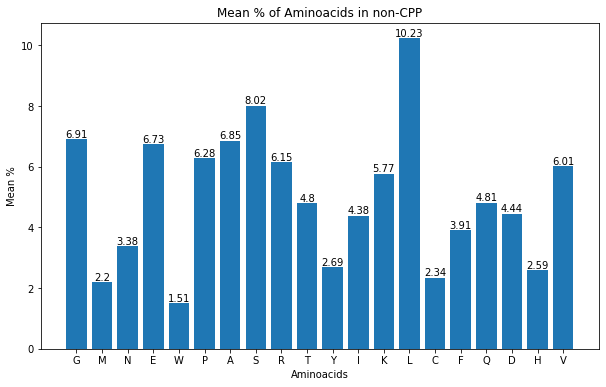

In [150]:
plot_mean_barplot(seq_df_good, letcols, xlabel='Aminoacids', ylabel='Mean %', title='Mean % of Aminoacids in CPP')
plot_mean_barplot(seq_df_bad, letcols, xlabel='Aminoacids', ylabel='Mean %', title='Mean % of Aminoacids in non-CPP')

### Выводы
- Содержание аминокислот в CPPs и non-CPPs отличаются, однако в большинстве случаев эти различия не очень велики
  
- Наиболее значимые отличия таковы: в CPPs чаще, чем в non-CPPs встречаются положительно заряженные аминокислоты R и K (аргинин и лизин); в non-CPPs чаще, чем в CPPs встречаются аминокислоты E, S, V (глутаминовая кислота, серин, валин)
  
- глутаминовая кислота заряжена отрицательно, что может мешать адгезии к отрицательно заряженной мембране (наличие положительно заряженных аминокислот наоборот этому способствует); серин, будучи гидрофильным может мешать прохождению через гидрофобную мембрану 

## Выравнивание

<Axes: >

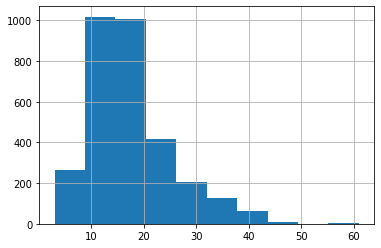

In [151]:
seq_df['Length'] = seq_df['sequence'].apply(len)
seq_df['Length'].hist()

In [ ]:
#отбор 100 последовательностей cpp 
# align_df = seq_df_good.copy()
# align_df = df.sample(n=100)
# align_df = pd.DataFrame(align_df['sequence'])
# align_df.to_csv('to_align.csv')

### Выравнивание 100 CPPs

In [152]:
from pymsaviz import MsaViz

msa_file = 'alignment.fasta'
mv = MsaViz(msa_file, color_scheme="Taylor", wrap_length=80, show_grid=True, show_consensus=True)
mv.savefig('alignment.png')

In [153]:
from PIL import Image
img = Image.open('alignment.png')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot()
ax.imshow(img)
 
plt.show()

In [154]:
#import our three important packages
from Bio import SeqIO
from Bio import AlignIO
from Bio import Phylo
with open("alignment.fasta","r") as clw: 
    alignment = AlignIO.read(clw,"fasta")

from Bio.Phylo.TreeConstruction import DistanceCalculator 
calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment)

from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()

# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distance_matrix)
# Make a better looking tree using the features of matplotlib 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50, 30), dpi=300) # create figure & set the size 
# matplotlib.rc('font', size=18)              # fontsize of the leaf and node labels 
# matplotlib.rc('xtick', labelsize=16)       # fontsize of the tick labels
# matplotlib.rc('ytick', labelsize=16)       # fontsize of the tick labels


axes = fig.add_subplot(1, 1, 1)
Phylo.draw(NJTree, axes=axes)

### Выводы
- некоторые пептиды схожи по последовательности и объединяются в кластеры, однако малая длина не позволяет добиться высокого качества выравнивания
- в консенсусной последовательности преобладают положительно заряженные (R, K) и гидрофобные (F, I, L, P) аминокислоты
- Кластеризация пептидов видна на филогенетическом дереве, однако эволюционные расстояния между ними достаточно велики 

# Some structure anecdotal data

Посмотрим на структуры 5 случайных CPPs из базы данных CPPsite 2.0 PDB structures
(https://webs.iiitd.edu.in/raghava/cppsite/downloads.php)

In [175]:
import py3Dmol

# Загрузка PDB файла
pdb_file1 = open('1134.pdb', 'r').read()
pdb_file2 = open('1490.pdb', 'r').read()
pdb_file3 = open('2520.pdb', 'r').read()
pdb_file4 = open('1432.pdb', 'r').read()
pdb_file5 = open('1643.pdb', 'r').read()

# Создание объекта py3Dmol view
view = py3Dmol.view(width=800, height=400)

# Добавление структуры из PDB файла
view.addModel(pdb_file1, 'pdb')
view.addModel(pdb_file2, 'pdb')
view.addModel(pdb_file3, 'pdb')


# Установка стиля и отображение
view.setStyle({'cartoon': {'color':'red'}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [176]:
view = py3Dmol.view(width=800, height=400)
view.addModel(pdb_file4, 'pdb')
view.addModel(pdb_file5, 'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

По визуализациям структур можно заметить, что
- многие CPPs имеют альфа-спирали в своей вторичной структуре, которые расположены в середине последовательности или на ее концах
  
- CPP, не имеющие регулярной вторичной структуры также встречаются

# Models based on amino acid frequences and encoding

### Добавить доли важных аминокислот

In [158]:
full_binary_df_with_aa = pd.concat([
    enriched_binary_df.reset_index().drop(columns='index') ,
    new_full_fasta_df_descriptors.reset_index().drop(columns='index') 
], axis=1, ignore_index=False)

full_binary_df_with_aa = full_binary_df_with_aa.loc[:,~full_binary_df_with_aa.columns.duplicated()]

full_binary_df_with_aa

uptake_type 
 sequence 
 biotin_o 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 ... 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 charge_at_ph 
 sequence_len 
 
 
 
 
 0 
 0 
 GTRTDSREDEI 
 0 
 0.545 
 0.273 
 0.182 
 0.182 
 0.545 
 0.273 
 0.364 
 ... 
 71.409091 
 4.316717 
 0.181818 
 0.363636 
 0.272727 
 0 
 0 
 -1.918182 
 -2.232056 
 11 
 
 
 1 
 0 
 VLPAWQGYHPM 
 0 
 0.182 
 0.455 
 0.364 
 0.455 
 0.091 
 0.455 
 0.455 
 ... 
 38.136364 
 6.710264 
 0.272727 
 0.272727 
 0.363636 
 6990 
 6990 
 -0.072727 
 -0.179836 
 11 
 
 
 2 
 0 
 AQPLWGLLSFLPL 
 0 
 0.231 
 0.615 
 0.154 
 0.692 
 0.077 
 0.231 
 0.538 
 ... 
 49.100000 
 5.570017 
 0.461538 
 0.307692 
 0.538462 
 5500 
 5500 
 1.138462 
 -0.204125 
 13 
 
 
 3 
 0 
 LPLESGNCAPF 
 0 
 0.273 
 0.636 
 0.091 
 0.545 
 0.182 
 0.273 
 0.364 
 ... 
 68.790909 
 4.050028 
 0.363636 
 0.454545 
 0.272727 
 0 
 0 
 0.300000 
 -1.246989 
 11 
 
 
 4 
 0 
 LFWLGWLGML 
 0 
 0.200 
 0.400 
 0.400 
 0.900 
 0.000 
 0.100 
 0.500 
 ... 
 46.020000 
 5.525000 
 0.500000 
 0.200000 
 0.700000 
 11000 
 11000 
 1.730000 
 -0.239898 
 10 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 1 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 0 
 0.286 
 0.250 
 0.464 
 0.250 
 0.607 
 0.143 
 0.679 
 ... 
 134.914286 
 11.910421 
 0.357143 
 0.178571 
 0.142857 
 0 
 0 
 -1.935714 
 8.753855 
 28 
 
 
 3117 
 1 
 WLRRIKAWLRRIKALNRQLGVAA 
 0 
 0.217 
 0.391 
 0.391 
 0.609 
 0.391 
 0.000 
 0.696 
 ... 
 87.843478 
 11.999968 
 0.434783 
 0.086957 
 0.391304 
 11000 
 11000 
 -0.169565 
 6.758054 
 23 
 
 
 3118 
 1 
 GRKKRRQRRRPP 
 0 
 0.083 
 0.250 
 0.667 
 0.083 
 0.750 
 0.167 
 0.750 
 ... 
 227.683333 
 11.999968 
 0.166667 
 0.250000 
 0.000000 
 0 
 0 
 -3.491667 
 7.758044 
 12 
 
 
 3119 
 1 
 RRRRRRRRR 
 0 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 ... 
 518.044444 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 8.760012 
 9 
 
 
 3120 
 1 
 RRRRRRRR 
 0 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 ... 
 509.950000 
 11.999968 
 0.000000 
 0.000000 
 0.000000 
 0 
 0 
 -4.500000 
 7.760022 
 8 
 
 
 
 3121 rows × 57 columns

In [159]:
def add_aa_percentages(df, aa_list):
    """
    Adds columns to the DataFrame with the percentage of each specified amino acid in the sequence.

    Parameters:
    df (pd.DataFrame): DataFrame containing the sequences.
    aa_list (list of str): List of amino acids to compute percentages for.

    Returns:
    pd.DataFrame: DataFrame with additional columns for each amino acid percentage.
    """
    for aa in aa_list:
        df[aa + '_percentage'] = df['sequence'].apply(lambda x: x.count(aa) / len(x) * 100 if len(x) > 0 else 0)
    return df

In [160]:
amino_acids = ['R', 'K', 'S', 'E']

In [161]:
add_aa_percentages(full_binary_df_with_aa, amino_acids)

uptake_type 
 sequence 
 biotin_o 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 ... 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 charge_at_ph 
 sequence_len 
 R_percentage 
 K_percentage 
 S_percentage 
 E_percentage 
 
 
 
 
 0 
 0 
 GTRTDSREDEI 
 0 
 0.545 
 0.273 
 0.182 
 0.182 
 0.545 
 0.273 
 0.364 
 ... 
 0.272727 
 0 
 0 
 -1.918182 
 -2.232056 
 11 
 18.181818 
 0.000000 
 9.090909 
 18.181818 
 
 
 1 
 0 
 VLPAWQGYHPM 
 0 
 0.182 
 0.455 
 0.364 
 0.455 
 0.091 
 0.455 
 0.455 
 ... 
 0.363636 
 6990 
 6990 
 -0.072727 
 -0.179836 
 11 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2 
 0 
 AQPLWGLLSFLPL 
 0 
 0.231 
 0.615 
 0.154 
 0.692 
 0.077 
 0.231 
 0.538 
 ... 
 0.538462 
 5500 
 5500 
 1.138462 
 -0.204125 
 13 
 0.000000 
 0.000000 
 7.692308 
 0.000000 
 
 
 3 
 0 
 LPLESGNCAPF 
 0 
 0.273 
 0.636 
 0.091 
 0.545 
 0.182 
 0.273 
 0.364 
 ... 
 0.272727 
 0 
 0 
 0.300000 
 -1.246989 
 11 
 0.000000 
 0.000000 
 9.090909 
 9.090909 
 
 
 4 
 0 
 LFWLGWLGML 
 0 
 0.200 
 0.400 
 0.400 
 0.900 
 0.000 
 0.100 
 0.500 
 ... 
 0.700000 
 11000 
 11000 
 1.730000 
 -0.239898 
 10 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3116 
 1 
 KRRIRRERNKMAAAKSRNRRRELTDTGC 
 0 
 0.286 
 0.250 
 0.464 
 0.250 
 0.607 
 0.143 
 0.679 
 ... 
 0.142857 
 0 
 0 
 -1.935714 
 8.753855 
 28 
 32.142857 
 10.714286 
 3.571429 
 7.142857 
 
 
 3117 
 1 
 WLRRIKAWLRRIKALNRQLGVAA 
 0 
 0.217 
 0.391 
 0.391 
 0.609 
 0.391 
 0.000 
 0.696 
 ... 
 0.391304 
 11000 
 11000 
 -0.169565 
 6.758054 
 23 
 21.739130 
 8.695652 
 0.000000 
 0.000000 
 
 
 3118 
 1 
 GRKKRRQRRRPP 
 0 
 0.083 
 0.250 
 0.667 
 0.083 
 0.750 
 0.167 
 0.750 
 ... 
 0.000000 
 0 
 0 
 -3.491667 
 7.758044 
 12 
 50.000000 
 16.666667 
 0.000000 
 0.000000 
 
 
 3119 
 1 
 RRRRRRRRR 
 0 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 ... 
 0.000000 
 0 
 0 
 -4.500000 
 8.760012 
 9 
 100.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 3120 
 1 
 RRRRRRRR 
 0 
 0.000 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 1.000 
 ... 
 0.000000 
 0 
 0 
 -4.500000 
 7.760022 
 8 
 100.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 
 3121 rows × 61 columns

### Длина последовательности

<Axes: >

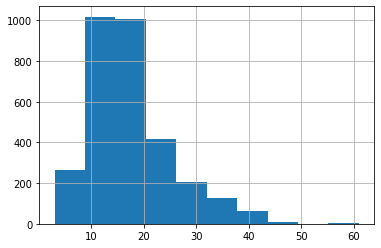

In [162]:
full_binary_df_with_aa.sequence_len.hist()

In [163]:
MAX_LEN = 40

### Представить последовательности в виде categorical features и обучить catboost

In [164]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [165]:
# Custom transformer to extract amino acids at each position
class SequencePositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=40):
        self.max_len = max_len
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]  # Truncate sequences longer than max_len
            seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X' (to represent no amino acid)
            X_transformed.append(list(seq_padded))
        return X_transformed

In [166]:
# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', Pipeline(steps=[
            ('seq_pos', SequencePositionTransformer(max_len=MAX_LEN)),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), 'sequence')
    ],
    remainder='passthrough'  # Pass through other columns without transformation
)

<Axes: >

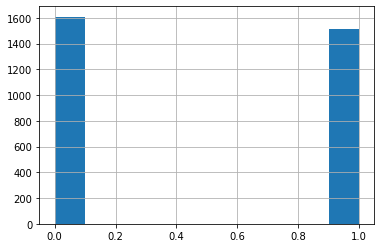

In [167]:
full_binary_df_with_aa.uptake_type.hist()

In [168]:
# Encode the target variable
label_encoder = LabelEncoder()
full_binary_df_with_aa['uptake_type'] = label_encoder.fit_transform(full_binary_df_with_aa['uptake_type'])

# Define the features and target
X = full_binary_df_with_aa.drop(columns=['uptake_type'])
y = full_binary_df_with_aa['uptake_type']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(silent=True))
])

In [171]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7fb00c1dfe80>)]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7fb00c1dfe80>)]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')]) seq sequence SequencePositionTransformer SequencePositionTransformer() OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) remainder ['biotin_o', '_PolarizabilityC1', '_PolarizabilityC2', '_PolarizabilityC3', '_SolventAccessibilityC1', '_SolventAccessibilityC2', '_SolventAccessibilityC3', '_SecondaryStrC1', '_SecondaryStrC2', '_SecondaryStrC3', '_ChargeC1', '_ChargeC2', '_ChargeC3', '_PolarityC1', '_PolarityC2', '_PolarityC3', '_NormalizedVDWVC1', '_NormalizedVDWVC2', '_NormalizedVDWVC3', '_HydrophobicityC1', '_HydrophobicityC2', '_HydrophobicityC3', '_PolarizabilityT12', '_PolarizabilityT13', '_PolarizabilityT23', '_SolventAccessibilityT12', '_SolventAccessibilityT13', '_SolventAccessibilityT23', '_SecondaryStrT12', '_SecondaryStrT13', '_SecondaryStrT23', '_ChargeT12', '_ChargeT13', '_ChargeT23', '_PolarityT12', '_PolarityT13', '_PolarityT23', '_NormalizedVDWVT12', '_NormalizedVDWVT13', '_NormalizedVDWVT23', '_HydrophobicityT12', '_HydrophobicityT13', '_HydrophobicityT23', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction', 'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'gravy', 'charge_at_ph', 'sequence_len', 'R_percentage', 'K_percentage', 'S_percentage', 'E_percentage'] passthrough passthrough CatBoostClassifier <catboost.core.CatBoostClassifier object at 0x7fb00c1dfe80>

In [172]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

F1 Score: 0.8939929328621908
AUC: 0.959878770385337


In [173]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<Axes: >

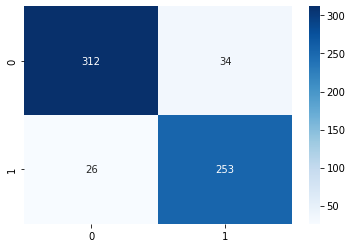

In [174]:
cfm = confusion_matrix(y_pred,y_test)
sns.heatmap(cfm, annot=True, cmap="Blues", fmt='g')

### Tuning

In [179]:
import optuna
from catboost import Pool

def objective(trial):
    # Define hyperparameters to tune
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }


    # Create the pipeline with tuned CatBoostClassifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(**params, silent=True))
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    return auc

In [184]:
# # Run optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Print best hyperparameters and AUC
# print('Best hyperparameters:', study.best_params)
# print('Best AUC:', study.best_value)

Best hyperparameters: {'learning_rate': 0.06552972965346537, 'depth': 5, 'subsample': 0.741915154389214, 'colsample_bylevel': 0.3349901197704242, 'min_data_in_leaf': 17}
Best AUC: 0.95953858524215


[I 2024-07-22 16:39:35,405] A new study created in memory with name: no-name-36939540-8e77-4c0d-96b2-395752505477
[I 2024-07-22 16:40:06,536] Trial 0 finished with value: 0.95953858524215 and parameters: {'learning_rate': 0.06552972965346537, 'depth': 5, 'subsample': 0.741915154389214, 'colsample_bylevel': 0.3349901197704242, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.95953858524215.
[I 2024-07-22 16:40:17,949] Trial 1 finished with value: 0.9589922272849102 and parameters: {'learning_rate': 0.030978992100451273, 'depth': 7, 'subsample': 0.37560158708273356, 'colsample_bylevel': 0.24944586330023977, 'min_data_in_leaf': 64}. Best is trial 0 with value: 0.95953858524215.
[I 2024-07-22 16:41:18,496] Trial 2 finished with value: 0.9585592643753995 and parameters: {'learning_rate': 0.022179583194559743, 'depth': 9, 'subsample': 0.13638033415898693, 'colsample_bylevel': 0.657468449754626, 'min_data_in_leaf': 95}. Best is trial 0 with value: 0.95953858524215.
[I 2024-07-22 16:41:3

In [180]:
BEST_PARAMS = {
    'learning_rate': 0.06552972965346537,
    'depth': 5,
    'subsample': 0.741915154389214,
    'colsample_bylevel': 0.3349901197704242,
    'min_data_in_leaf': 17
}

In [182]:
# Train the final model with the best hyperparameters
best_params = BEST_PARAMS
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(**best_params, silent=True))
])
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f'Final F1 Score: {f1}')
print(f'Final AUC: {auc}')

Final F1 Score: 0.9055944055944056
Final AUC: 0.9615900047419748


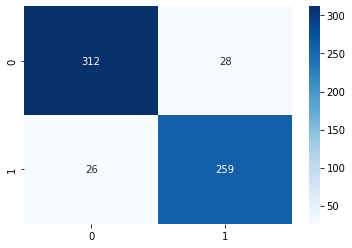

In [184]:
cfm = confusion_matrix(y_pred,y_test)
sns.heatmap(cfm, annot=True, cmap="Blues", fmt='g')
plt.show()

### Регрессия вместе с исходными фичами 

In [169]:
from catboost import CatBoostRegressor

In [170]:
full_poseidon_no_conc_drop_nan

cleaned_sequence 
 _PolarizabilityC1 
 _PolarizabilityC2 
 _PolarizabilityC3 
 _SolventAccessibilityC1 
 _SolventAccessibilityC2 
 _SolventAccessibilityC3 
 _SecondaryStrC1 
 _SecondaryStrC2 
 _SecondaryStrC3 
 ... 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 sequence 
 charge_at_ph 
 sequence_len 
 
 
 
 
 0 
 RKKRRQRRR 
 0.0 
 0.111 
 0.889 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.222222 
 0.0 
 0.0 
 0 
 0 
 -4.255556 
 RKKRRQRRR 
 7.758044 
 9 
 
 
 1 
 RKKRRQRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 RKKRRQRR 
 6.758054 
 8 
 
 
 2 
 RKKRRQR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.285714 
 0.0 
 0.0 
 0 
 0 
 -4.185714 
 RKKRRQR 
 5.758064 
 7 
 
 
 3 
 KKRRQRRR 
 0.0 
 0.125 
 0.875 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 KKRRQRRR 
 6.758054 
 8 
 
 
 4 
 KRRQRRR 
 0.0 
 0.143 
 0.857 
 0.0 
 1.000 
 0.000 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.142857 
 0.0 
 0.0 
 0 
 0 
 -4.271429 
 KRRQRRR 
 5.759053 
 7 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1519 
 RRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.600 
 0.400 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -3.980000 
 RRHRHRHRHR 
 6.108738 
 10 
 
 
 1520 
 RRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.636 
 0.364 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.027273 
 RRRHRHRHRHR 
 7.108728 
 11 
 
 
 1521 
 RRRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.667 
 0.333 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.066667 
 RRRRHRHRHRHR 
 8.108718 
 12 
 
 
 1522 
 RRRRRHRHRHRHR 
 0.0 
 0.000 
 1.000 
 0.0 
 0.692 
 0.308 
 1.0 
 0.0 
 0.0 
 ... 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.100000 
 RRRRRHRHRHRHR 
 9.108708 
 13 
 
 
 1523 
 CRWRWKCCKK 
 0.0 
 0.300 
 0.700 
 0.5 
 0.500 
 0.000 
 0.5 
 0.5 
 0.0 
 ... 
 9.898170 
 0.300000 
 0.0 
 0.2 
 11000 
 11125 
 -1.500000 
 CRWRWKCCKK 
 4.727382 
 10 
 
 
 
 1524 rows × 56 columns

In [171]:
catboost_regresson_df = pd.concat(
    [full_poseidon_no_conc_drop_nan[BIOPPYTHON_FEATURE_NAMES + ['sequence_len']],
     poseidon_no_conc_drop_nan.drop(columns=['Sequence']).set_index(full_poseidon_no_conc_drop_nan.index)],
    axis=1, ignore_index=False
)
catboost_regresson_df

molecular_weight 
 aromaticity 
 instability_index 
 isoelectric_point 
 helix_fraction 
 turn_fraction 
 sheet_fraction 
 molar_extinction_coefficient_reduced 
 molar_extinction_coefficient_oxidized 
 gravy 
 ... 
 Uptake 
 Units 
 Time 
 Temp. 
 Method 
 Type 
 new_uptake 
 nht_tail 
 acylated_terminal 
 cleaned_sequence 
 
 
 
 
 0 
 1339.6033 
 0.0 
 257.444444 
 11.999968 
 0.222222 
 0.0 
 0.0 
 0 
 0 
 -4.255556 
 ... 
 650 
 Mean Fluorescence intensity 
 15.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 650.00 
 0 
 0 
 RKKRRQRRR 
 
 
 1 
 1183.4176 
 0.0 
 216.775000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 ... 
 31.25 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 31.25 
 0 
 0 
 RKKRRQRR 
 
 
 2 
 1027.2319 
 0.0 
 164.485714 
 11.999968 
 0.285714 
 0.0 
 0.0 
 0 
 0 
 -4.185714 
 ... 
 10 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 10.00 
 0 
 0 
 RKKRRQR 
 
 
 3 
 1183.4176 
 0.0 
 288.375000 
 11.999968 
 0.250000 
 0.0 
 0.0 
 0 
 0 
 -4.225000 
 ... 
 22.5 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 22.50 
 0 
 0 
 KKRRQRRR 
 
 
 4 
 1055.2453 
 0.0 
 328.142857 
 11.999968 
 0.142857 
 0.0 
 0.0 
 0 
 0 
 -4.271429 
 ... 
 20 
 Mean Fluorescence intensity 
 10.0 
 23.0 
 Flow cytometry 
 Cellular uptake 
 20.00 
 0 
 0 
 KRRQRRR 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1519 
 1503.6867 
 0.0 
 143.320000 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -3.980000 
 ... 
 100 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 100.00 
 0 
 0 
 RRHRHRHRHR 
 
 
 1520 
 1659.8724 
 0.0 
 183.272727 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.027273 
 ... 
 250 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 250.00 
 0 
 0 
 RRRHRHRHRHR 
 
 
 1521 
 1816.0581 
 0.0 
 216.566667 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.066667 
 ... 
 400 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 400.00 
 0 
 0 
 RRRRHRHRHRHR 
 
 
 1522 
 1972.2438 
 0.0 
 244.738462 
 11.999968 
 0.000000 
 0.0 
 0.0 
 0 
 0 
 -4.100000 
 ... 
 500 
 Mean Fluorescence intensity 
 1440.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 500.00 
 0 
 0 
 RRRRRHRHRHRHR 
 
 
 1523 
 1396.7521 
 0.2 
 123.560000 
 9.898170 
 0.300000 
 0.0 
 0.2 
 11000 
 11125 
 -1.500000 
 ... 
 7000 
 corr. Fluorescence 
 1080.0 
 37.0 
 Flow cytometry 
 Cellular internalization of oleyl 
 7000.00 
 0 
 0 
 CRWRWKCCKK 
 
 
 
 1524 rows × 26 columns

In [172]:
catboost_regresson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   molecular_weight                       1524 non-null   float64
 1   aromaticity                            1524 non-null   float64
 2   instability_index                      1524 non-null   float64
 3   isoelectric_point                      1524 non-null   float64
 4   helix_fraction                         1524 non-null   float64
 5   turn_fraction                          1524 non-null   float64
 6   sheet_fraction                         1524 non-null   float64
 7   molar_extinction_coefficient_reduced   1524 non-null   int64  
 8   molar_extinction_coefficient_oxidized  1524 non-null   int64  
 9   gravy                                  1524 non-null   float64
 10  charge_at_ph                           1524 non-null   float64
 11  sequ

In [173]:
catboost_regresson_df = catboost_regresson_df.drop(columns=['Peptide', 'Uptake', 'Units', 'PubmedID'])

In [174]:
catboost_regresson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   molecular_weight                       1524 non-null   float64
 1   aromaticity                            1524 non-null   float64
 2   instability_index                      1524 non-null   float64
 3   isoelectric_point                      1524 non-null   float64
 4   helix_fraction                         1524 non-null   float64
 5   turn_fraction                          1524 non-null   float64
 6   sheet_fraction                         1524 non-null   float64
 7   molar_extinction_coefficient_reduced   1524 non-null   int64  
 8   molar_extinction_coefficient_oxidized  1524 non-null   int64  
 9   gravy                                  1524 non-null   float64
 10  charge_at_ph                           1524 non-null   float64
 11  sequ

In [175]:
catboost_regresson_df['Type'].value_counts()

Cellular uptake 867
Uptake 360
Internalization 91
Penetration efficiencies 55
Transfection 48
Translocation 27
Cell-Penetration 11
Transduction 8
Penetration 8
Cellular internalization of oleyl 7
Internalization efficency 6
CPP activity 6
Association 5
Internalization of fluorescently labeled peptides 4
QD internalization 4
Uptake (Endosomal escape) 3
Live cell peptide uptake 3
Cellular internalization 2
Drug transport 2
Intracellular uptake 2
Interalization 1
Relative uptake 1
Antigen Uptake 1
Cellular uptake of LNC-(DiD) 1
Absorption 1
Name: Type, dtype: int64

In [176]:
catboost_regresson_df['Cargo'].value_counts()

FITC 292
Fluorescein 215
Carboxyfluorescein 121
QDs 73
TAMRA 67
 ... 
CROP 1
SLO 1
CT-B 1
Tf 1
siRNA-A493 1
Name: Cargo, Length: 133, dtype: int64

In [177]:
catboost_regresson_df['Cell line'].value_counts()

HeLa cells 364
MCF7 cells 94
A549 cells 92
CHO cells 77
HEK293T cells 70
 ... 
C6 cells 1
ZR-75-1 human breast cancer 1
S-180 sarcoma cells 1
M21 1
MEF cells 1
Name: Cell line, Length: 122, dtype: int64

In [ ]:
catboost_regresson_df = catboost_regresson_df.drop(columns=['Cargo', 'Type'])

<Axes: >

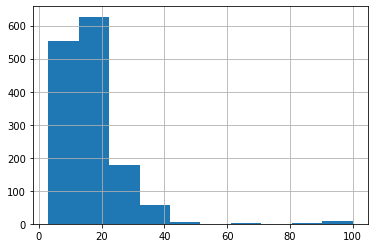

In [195]:
catboost_regresson_df.sequence_len.hist()

In [196]:
# Define the features and target
X = catboost_regresson_df.drop(columns=['new_uptake'])
y = catboost_regresson_df['new_uptake']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
# Custom transformer to extract amino acids at each position
class SequencePositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=40):
        self.max_len = max_len
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]  # Truncate sequences longer than max_len
            seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X' (to represent no amino acid)
            X_transformed.append(list(seq_padded))
        return X_transformed

In [199]:
# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', Pipeline(steps=[
            ('seq_pos', SequencePositionTransformer(max_len=MAX_LEN)),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), 'cleaned_sequence')
    ],
    remainder='passthrough'  # Pass through other columns without transformation
)

In [201]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(silent=True))
])

In [202]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Error: Error: begin 0, end -1, length 0

# < < < КОНЕЦ > > > 